In [1]:
# # 압축파일 풀기
# !unzip data/larger_dataset_with_ICBHI.zip -d data/ICBHI_database

In [2]:
import os
import gc
from time import time

import natsort
from itertools import count
# import torch
# from pydub import AudioSegment, silence

# Math
from scipy.io import wavfile
import librosa
import numpy as np
from scipy import signal
from scipy.signal import find_peaks

# # Visualization
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.lines import Line2D

import librosa.display
from IPython.display import Audio
from IPython.display import HTML

import itertools
import noisereduce as nr
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler
import sklearn

# keras module
import tensorflow as tf
# from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras import utils
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, Conv2D, MaxPooling1D, Embedding, LSTM, Bidirectional, SimpleRNN, GRU

from tensorflow.keras.layers import *
from tensorflow.keras.models import *

# Hyperparameters
freq_lim = 2048

In [3]:
import os

from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# import mglearn
from os.path import join

from sklearn.model_selection import train_test_split, train_test_split, cross_val_score, KFold
from sklearn.preprocessing import MinMaxScaler, label_binarize, OneHotEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn import ensemble
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer,accuracy_score,f1_score,roc_auc_score,roc_curve,confusion_matrix,auc
from sklearn.metrics import RocCurveDisplay,confusion_matrix, ConfusionMatrixDisplay

# import umap
from sklearn.manifold import TSNE

import joblib

In [4]:
tf.__version__

'2.1.0'

In [5]:
# from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

In [6]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 3076809361076611928,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 541741844617841829
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 2582072297148173596
 physical_device_desc: "device: XLA_GPU device",
 name: "/device:XLA_GPU:1"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 16710324255057575983
 physical_device_desc: "device: XLA_GPU device",
 name: "/device:XLA_GPU:2"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 6829115880827026081
 physical_device_desc: "device: XLA_GPU device",
 name: "/device:XLA_GPU:3"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 18413953819754572804
 physical_device_desc: "device: XLA_GPU device",
 

In [7]:
for i in range(2):
    gc.collect()
gc.collect()

0

# Funcition definition 

In [8]:
def make_train_dataset_sklearn(file_path, ordered_file_list, n_mels, frame_sec, step_sec, label_ratio):
    
    data_list = []
    label_list = []
    
    pitch_var = [-3.5, -2, 2, 3.5]
    augmented_number = len(pitch_var)

    for index, file in enumerate(ordered_file_list):
        
        if file[-3:] == 'wav':

            # data load 
            sample_rate = librosa.get_samplerate(file_path + '/' + file)
            # calculated values
            frame_length = int(frame_sec * sample_rate)
            frame_step = int(step_sec * sample_rate)
            data, data_sr = librosa.load(file_path + '/' + file, sr = sample_rate)
            
            for pitch in pitch_var:
                
                ps_data = librosa.effects.pitch_shift(data, sr = sample_rate, n_steps = pitch)

                # mel spectrogram extraction
                melS = librosa.feature.melspectrogram(y = ps_data, sr=sample_rate, n_mels=n_mels,
                                                      hop_length=frame_step, win_length=frame_length)
                melS = librosa.power_to_db(melS, ref=np.max)

                data_list.append(melS.T)
                
            # normal and wheeze split
            normal_event = []
            wheeze_event = []
                
            label = pd.read_csv(file_path + '/' + file[:-3] + 'txt', sep='\t', header=None)
            
            sec_to_index_start = label[0]*sample_rate
            sec_to_index_end = label[1]*sample_rate
            sec_to_index_start = sec_to_index_start.to_numpy().round()
            sec_to_index_end = sec_to_index_end.to_numpy().round()

            for i, val in enumerate(label[2].to_numpy()):
                if val == 'normal':
                    normal_event.append([int(sec_to_index_start[i]//(step_sec*sample_rate)),
                                         int(sec_to_index_end[i]//(step_sec*sample_rate))])

                elif val == 'wheeze':
                    wheeze_event.append([int(sec_to_index_start[i]//(step_sec*sample_rate)),
                                         int(sec_to_index_end[i]//(step_sec*sample_rate))])

            normal_event = np.array(normal_event)
            wheeze_event = np.array(wheeze_event)
            
            y = np.zeros(len(data_list[-1]))
 
            # label ratio decision
            for j in normal_event:
                start = j[0]
                end = j[1]
                delta = int((end-start)*label_ratio)
                y[end-delta:end] = 1

            for k in wheeze_event:
                start = k[0]
                end = k[1]
                delta = int((end-start)*label_ratio)
                y[end-delta:end] = 2
                
            for number in range(augmented_number):
                label_list.append(y)
                
    X = np.concatenate(data_list, axis = 0)
#     X = X.reshape(X.shape[0], X.shape[1], 1)
    y = np.concatenate(label_list, axis = 0)
#     y = utils.to_categorical(y)
    
    return X, y


def make_validation_dataset_sklearn(file_path, ordered_file_list, n_mels, frame_sec, step_sec, label_ratio):

    data_list = []
    label_list = []

    for index, file in enumerate(ordered_file_list):
        if file[-3:] == 'wav':
            
            # data load 
            sample_rate = librosa.get_samplerate(file_path + '/' + file)
            data, data_sr = librosa.load(file_path + '/' + file, sr = sample_rate)

            # framing condition
            frame_length = int(frame_sec * sample_rate)
            frame_step = int(step_sec * sample_rate)

            # mel spectrogram extraction
            melS = librosa.feature.melspectrogram(y = data, sr=sample_rate, n_mels=n_mels,
                                                  hop_length=frame_step, win_length=frame_length)
            melS = librosa.power_to_db(melS, ref=np.max)
#             melS = librosa.power_to_db(melS, ref=np.median)

            data_list.append(melS.T)

    # X must be extracted first

    for index, file in enumerate(ordered_file_list):

        if file[-3:] == 'txt':

            # normal and wheeze split
            normal_event = []
            wheeze_event = []

            label = pd.read_csv(file_path + '/' + file, sep='\t', header=None)

            sec_to_index_start = label[0]*sample_rate
            sec_to_index_end = label[1]*sample_rate
            sec_to_index_start = sec_to_index_start.to_numpy().round()
            sec_to_index_end = sec_to_index_end.to_numpy().round()

            for i, val in enumerate(label[2].to_numpy()):
                if val == 1:
                    normal_event.append([int(sec_to_index_start[i]//(step_sec*sample_rate)), 
                                         int(sec_to_index_end[i]//(step_sec*sample_rate))])

                elif val == 2:
                    wheeze_event.append([int(sec_to_index_start[i]//(step_sec*sample_rate)), 
                                         int(sec_to_index_end[i]//(step_sec*sample_rate))])

            normal_event = np.array(normal_event)
            wheeze_event = np.array(wheeze_event)

            y = np.zeros(len(data_list[int(index/2)]))

            # label ratio decision

            for j in normal_event:
                start = j[0]
                end = j[1]
                delta = int((end-start)*label_ratio)
                y[end-delta:end] = 1
#                 y[end:end+delta] = 1


            for k in wheeze_event:
                start = k[0]
                end = k[1]
                delta = int((end-start)*label_ratio)
                y[end-delta:end] = 2
#                 y[end:end+delta] = 2


            label_list.append(y)
    
    X = np.concatenate(data_list, axis = 0)
    X = X.reshape(X.shape[0], X.shape[1])
#     X = X.reshape(X.shape[0], X.shape[1], 1)
    y = np.concatenate(label_list, axis = 0)
#     y = utils.to_categorical(y)
    
    return X, y


def make_train_dataset_keras(file_path, ordered_file_list, n_mels, frame_sec, step_sec, label_ratio):
    
    data_list = []
    label_list = []
    
    pitch_var = [-3.5, -2, 2, 3.5]
    augmented_number = len(pitch_var)

    for index, file in enumerate(ordered_file_list):
        
        if file[-3:] == 'wav':

            # data load 
            sample_rate = librosa.get_samplerate(file_path + '/' + file)
            # calculated values
            frame_length = int(frame_sec * sample_rate)
            frame_step = int(step_sec * sample_rate)
            data, data_sr = librosa.load(file_path + '/' + file, sr = sample_rate)
            
            for pitch in pitch_var:
                
                ps_data = librosa.effects.pitch_shift(data, sr = sample_rate, n_steps = pitch)

                # mel spectrogram extraction
                melS = librosa.feature.melspectrogram(y = ps_data, sr=sample_rate, n_mels=n_mels,
                                                      hop_length=frame_step, win_length=frame_length)
                melS = librosa.power_to_db(melS, ref=np.max)

                data_list.append(melS.T)
                
            # normal and wheeze split
            normal_event = []
            wheeze_event = []
                
            label = pd.read_csv(file_path + '/' + file[:-3] + 'txt', sep='\t', header=None)
            
            sec_to_index_start = label[0]*sample_rate
            sec_to_index_end = label[1]*sample_rate
            sec_to_index_start = sec_to_index_start.to_numpy().round()
            sec_to_index_end = sec_to_index_end.to_numpy().round()

            for i, val in enumerate(label[2].to_numpy()):
                if val == 'normal':
                    normal_event.append([int(sec_to_index_start[i]//(step_sec*sample_rate)),
                                         int(sec_to_index_end[i]//(step_sec*sample_rate))])

                elif val == 'wheeze':
                    wheeze_event.append([int(sec_to_index_start[i]//(step_sec*sample_rate)),
                                         int(sec_to_index_end[i]//(step_sec*sample_rate))])

            normal_event = np.array(normal_event)
            wheeze_event = np.array(wheeze_event)
            
            y = np.zeros(len(data_list[-1]))
 
            # label ratio decision
            for j in normal_event:
                start = j[0]
                end = j[1]
                delta = int((end-start)*label_ratio)
                y[end-delta:end] = 1

            for k in wheeze_event:
                start = k[0]
                end = k[1]
                delta = int((end-start)*label_ratio)
                y[end-delta:end] = 2
                
            for number in range(augmented_number):
                label_list.append(y)
                
    X = np.concatenate(data_list, axis = 0)
    X = X.reshape(X.shape[0], X.shape[1], 1)
    y = np.concatenate(label_list, axis = 0)
    y = utils.to_categorical(y)
    
    return X, y


def make_validation_dataset_keras(file_path, ordered_file_list, n_mels, frame_sec, step_sec, label_ratio):


    data_list = []
    label_list = []

    for index, file in enumerate(ordered_file_list):
        if file[-3:] == 'wav':

            # data load 
            sample_rate = librosa.get_samplerate(file_path + '/' + file)
            data, data_sr = librosa.load(file_path + '/' + file, sr = sample_rate)

            # framing condition
            frame_length = int(frame_sec * sample_rate)
            frame_step = int(step_sec * sample_rate)

            # mel spectrogram extraction
            melS = librosa.feature.melspectrogram(y = data, sr=sample_rate, n_mels=n_mels,
                                                  hop_length=frame_step, win_length=frame_length)
            melS = librosa.power_to_db(melS, ref=np.max)
#             melS = librosa.power_to_db(melS, ref=np.median)

            data_list.append(melS.T)

    # X must be extracted first

    for index, file in enumerate(ordered_file_list):

        if file[-3:] == 'txt':

            # normal and wheeze split
            normal_event = []
            wheeze_event = []

            label = pd.read_csv(file_path + '/' + file, sep='\t', header=None)

            sec_to_index_start = label[0]*sample_rate
            sec_to_index_end = label[1]*sample_rate
            sec_to_index_start = sec_to_index_start.to_numpy().round()
            sec_to_index_end = sec_to_index_end.to_numpy().round()

            for i, val in enumerate(label[2].to_numpy()):
                if val == 1:
                    normal_event.append([int(sec_to_index_start[i]//(step_sec*sample_rate)), 
                                         int(sec_to_index_end[i]//(step_sec*sample_rate))])

                elif val == 2:
                    wheeze_event.append([int(sec_to_index_start[i]//(step_sec*sample_rate)), 
                                         int(sec_to_index_end[i]//(step_sec*sample_rate))])

            normal_event = np.array(normal_event)
            wheeze_event = np.array(wheeze_event)

            y = np.zeros(len(data_list[int(index/2)]))

            # label ratio decision

            for j in normal_event:
                start = j[0]
                end = j[1]
                delta = int((end-start)*label_ratio)
                y[end-delta:end] = 1
#                 y[end:end+delta] = 1


            for k in wheeze_event:
                start = k[0]
                end = k[1]
                delta = int((end-start)*label_ratio)
                y[end-delta:end] = 2
#                 y[end:end+delta] = 2


            label_list.append(y)
    
    X = np.concatenate(data_list, axis = 0)
    X = X.reshape(X.shape[0], X.shape[1])
    X = X.reshape(X.shape[0], X.shape[1], 1)
    y = np.concatenate(label_list, axis = 0)
    y = utils.to_categorical(y)
    
    return X, y


def make_test_dataset_keras(test_signal, test_label, n_mels, frame_sec, step_sec, sample_rate):
    
    # framing condition
    frame_length = int(frame_sec * sample_rate)
    frame_step = int(step_sec * sample_rate)

    # mel spectrogram extraction
    melS = librosa.feature.melspectrogram(y = test_signal, sr=sample_rate, 
                                          n_mels=n_mels, hop_length=frame_step, win_length=frame_length)
    melS = librosa.power_to_db(melS, ref=np.max)

    X_test = melS.T
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1],1)
    
    sec_to_index = test_label[0]*sample_rate
    event_index = sec_to_index//(step_sec*sample_rate)

    y_test = np.zeros(len(X_test))

    for i in event_index:
        y_test[int(i)] = 2
        
    return X_test, y_test


def make_test_dataset_keras_realtime(test_signal, test_label, n_mels, frame_sec, step_sec, sample_rate):
    
    # framing condition
    frame_length = int(frame_sec * sample_rate)
    frame_step = int(step_sec * sample_rate)

    # mel spectrogram extraction
    melS = librosa.feature.melspectrogram(y = test_signal, sr=sample_rate, 
                                          n_mels=n_mels, hop_length=frame_step, win_length=frame_length)
    melS = librosa.power_to_db(melS, ref=np.max)

    X_test = melS.T
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1],1)
    
    sec_to_index = test_label[0]*sample_rate
    event_index = sec_to_index//(step_sec*sample_rate)
    
    # normal and wheeze split
    normal_event = []
    wheeze_event = []

    sec_to_index_start = test_label[0]*sample_rate
    sec_to_index_end = test_label[1]*sample_rate
    sec_to_index_start = sec_to_index_start.to_numpy().round()
    sec_to_index_end = sec_to_index_end.to_numpy().round()

    for i, val in enumerate(test_label[2].to_numpy()):
        if val == 'n':
            normal_event.append([int(sec_to_index_start[i]//(step_sec*sample_rate)), 
                                 int(sec_to_index_end[i]//(step_sec*sample_rate))])

        elif val == 'w':
            wheeze_event.append([int(sec_to_index_start[i]//(step_sec*sample_rate)), 
                                 int(sec_to_index_end[i]//(step_sec*sample_rate))])

    normal_event = np.array(normal_event)
    wheeze_event = np.array(wheeze_event)

    y_test = np.zeros(len(X_test))

    # label ratio decision
    for j in normal_event:
        start = j[0]
        end = j[1]
        delta = int((end-start)*label_ratio)
        y_test[end-delta:end] = 1

    for k in wheeze_event:
        start = k[0]
        end = k[1]
        delta = int((end-start)*label_ratio)
        y_test[end-delta:end] = 2
    
    return X_test, y_test


def make_test_dataset_keras_realtime_2(test_signal, test_label, n_mels, frame_sec, step_sec, sample_rate):
    
    # framing condition
    frame_length = int(frame_sec * sample_rate)
    frame_step = int(step_sec * sample_rate)

    # mel spectrogram extraction
    melS = librosa.feature.melspectrogram(y = test_signal, sr=sample_rate, 
                                          n_mels=n_mels, hop_length=frame_step, win_length=frame_length)
    melS = librosa.power_to_db(melS, ref=np.max)

    X_test = melS.T
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1],1)
    
    sec_to_index = test_label[0]*sample_rate
    event_index = sec_to_index//(step_sec*sample_rate)

    y_test = np.zeros(len(X_test))

    for index, i in enumerate(event_index):
        if test_label[2].to_numpy()[index] == 'n':
            y_test[int(i)] = 1
            
        elif test_label[2].to_numpy()[index] == 'w':
            y_test[int(i)] = 2
            
    return X_test, y_test


def make_test_dataset_keras_without_label(test_signal, n_mels, frame_sec, step_sec, sample_rate):

    # framing condition
    frame_length = int(frame_sec * sample_rate)
    frame_step = int(step_sec * sample_rate)

    # mel spectrogram extraction
    melS = librosa.feature.melspectrogram(y = test_signal, sr=sample_rate, 
                                          n_mels=n_mels, hop_length=frame_step, win_length=frame_length)
    melS = librosa.power_to_db(melS, ref=np.max)

    X_test = melS.T
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1],1)
        
    return X_test


def wheeze_per_resp_acc(y_pred, y_test):
    
    peaks, _ = find_peaks(y_pred)

    after_peaks = peaks[1:]
    before_peaks = peaks[:-1]

    term = after_peaks - before_peaks

    start = 0
    pred_resp_count = 0
    pred_normal_count = 0
    pred_wheeze_count = 0

    for index, val in enumerate(term):
        if val >= 100:
            pred_resp_count += 1
            thres = y_pred[peaks[start:index+1]].mean()
            if thres > 1.0:
                pred_wheeze_count += 1
            elif thres == 1.0 : 
                pred_normal_count += 1
            start = index+1
    
    print('prediction')
    print(pred_wheeze_count, '/', pred_resp_count)
    
    peaks, _ = find_peaks(y_test)

    after_peaks = peaks[1:]
    before_peaks = peaks[:-1]

    term = after_peaks - before_peaks

    start = 0
    test_resp_count = 0
    test_normal_count = 0
    test_wheeze_count = 0

    for index, val in enumerate(term):
        if val >= 100:
            test_resp_count += 1
            thres = y_test[peaks[start:index+1]].mean()
            if thres > 1.0:
                test_wheeze_count += 1
            elif thres == 1.0 : 
                test_normal_count += 1
            start = index+1
             
    print('test')
    print(test_wheeze_count, '/', test_resp_count)
    
    return pred_wheeze_count, pred_resp_count

In [9]:
def algorithm_pipeline(X_train_data, X_test_data, y_train_data, y_test_data, 
                       model, param_grid, cv=5, scoring_fit='roc_auc',
                       do_probabilities = False):
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
#         cv=cv, 
        n_jobs=1, 
#         scoring=scoring_fit,
#         verbose=2
    )
    
    gs.fit(X_train_data, y_train_data)
    
    if do_probabilities:
        pred = gs.predict_proba(X_test_data)
    else:
        pred = gs.predict(X_test_data)
    
    return gs, pred

In [10]:
# ordered_file_list = ordered_file_list[1:]
# ordered_file_list

In [11]:
val_file_path= 'data/validation'

val_file_list = os.listdir(val_file_path)
val_ordered_file_list = natsort.natsorted(val_file_list)

val_ordered_file_list

['normal_littmann_1cycle.txt',
 'normal_littmann_1cycle.wav',
 'normal_sim_2cycles.txt',
 'normal_sim_2cycles.wav',
 'wheeze_clinical_validation.txt',
 'wheeze_clinical_validation.wav',
 'wheeze_expiratory_littmann_1cycle.txt',
 'wheeze_expiratory_littmann_1cycle.wav',
 'wheeze_low_pitch_littmann_1cycle.txt',
 'wheeze_low_pitch_littmann_1cycle.wav',
 'wheeze_monophonic_littmann_1cycle.txt',
 'wheeze_monophonic_littmann_1cycle.wav',
 'wheeze_sim_2cycles.txt',
 'wheeze_sim_2cycles.wav']

In [12]:
# val_ordered_file_list = val_ordered_file_list[1:]
# val_ordered_file_list

In [13]:
n_mels = 128
frame_sec = 0.025
step_sec = 0.01
label_ratio = 1

# X, y = make_train_dataset_sklearn(file_path, ordered_file_list, n_mels, frame_sec, step_sec, label_ratio)
X_test, y_test = make_validation_dataset_sklearn(val_file_path, val_ordered_file_list, n_mels, frame_sec, step_sec, label_ratio)
#%% Split data
# X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)
# n_timesteps, n_features, n_outputs = X.shape[1], X.shape[2], y.shape[1]

## Random Forest Classifier

### with k-fold, without sclaer, fix sample rate error 

acc: 0.8452173913043478
f1: 0.8509455354273302
roc_auc: 0.960877767175696
[[0.85563237 0.00569337 0.13867426]
 [0.04721754 0.82799325 0.12478921]
 [0.04727646 0.12332991 0.82939363]]


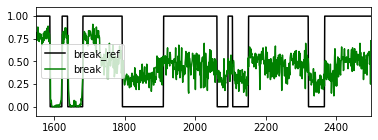

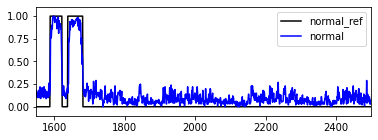

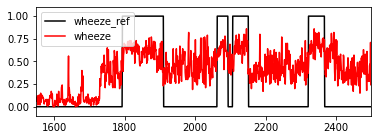

In [18]:
clf = joblib.load('saved_model/230730_RFC_larger_database_ICBHI_ref_max_cv_fold_10_train_with_9_without_scaler_fix_sample_rate_error.joblib')

##################################### confusion matrix
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)

acc =accuracy_score(y_test,y_pred)
f1=f1_score(y_test,y_pred,average='weighted')

y_true = utils.to_categorical(y_test)

roc_auc = roc_auc_score(y_true, y_prob, multi_class='ovr')
cm = confusion_matrix(y_test, y_pred, normalize='true')

print('acc:', acc)
print('f1:', f1)
print('roc_auc:', roc_auc)
print(cm)

###################################### graph visuallization
y_prob_0 = y_prob[:,0]
y_prob_1 = y_prob[:,1]
y_prob_2 = y_prob[:,2]

y_true_0 = y_true[:,0]
y_true_1 = y_true[:,1]
y_true_2 = y_true[:,2]

view_start = 1550
view_end = 2500

plt.figure(figsize=(6,2))
# plt.figure()
plt.plot(y_true_0, label='break_ref', color='black')
plt.plot(y_prob_0, label='break', color='g')
plt.ylim(-0.1,1.1)
plt.xlim(view_start,view_end)
plt.legend()
# plt.savefig('svg_images/figure6-1_break.svg')

plt.figure(figsize=(6,2))
plt.plot(y_true_1, label='normal_ref', color='black')
plt.plot(y_prob_1, label='normal', color='b')
plt.ylim(-0.1,1.1)
plt.xlim(view_start,view_end)
plt.legend()
# plt.savefig('svg_images/figure6-1_normal.svg')

plt.figure(figsize=(6,2))
plt.plot(y_true_2, label='wheeze_ref', color='black')
plt.plot(y_prob_2, label='wheeze', color='r')
plt.ylim(-0.1,1.1)
plt.xlim(view_start,view_end)
plt.legend()
# plt.savefig('svg_images/figure6-1_wheeze.svg')

### with k-fold, scaler 

acc: 0.8362732919254658
f1: 0.8414140628249657
roc_auc: 0.9555164463021505
[[0.85278569 0.00244002 0.1447743 ]
 [0.08094435 0.82293423 0.09612142]
 [0.06988695 0.1274409  0.80267215]]


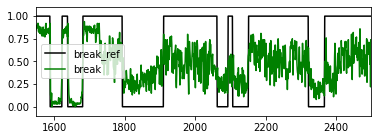

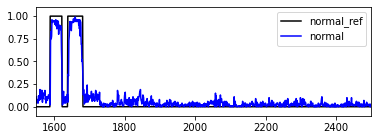

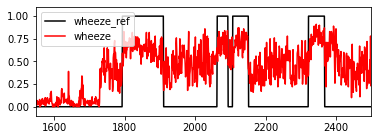

In [93]:
clf = joblib.load('saved_model/230730_RFC_larger_database_ICBHI_ref_max_cv_fold_10_train_with_9_with_scaler.joblib')

##################################### confusion matrix
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)

acc =accuracy_score(y_test,y_pred)
f1=f1_score(y_test,y_pred,average='weighted')

y_true = utils.to_categorical(y_test)

roc_auc = roc_auc_score(y_true, y_prob, multi_class='ovr')
cm = confusion_matrix(y_test, y_pred, normalize='true')

print('acc:', acc)
print('f1:', f1)
print('roc_auc:', roc_auc)
print(cm)

###################################### graph visuallization
y_prob_0 = y_prob[:,0]
y_prob_1 = y_prob[:,1]
y_prob_2 = y_prob[:,2]

y_true_0 = y_true[:,0]
y_true_1 = y_true[:,1]
y_true_2 = y_true[:,2]

view_start = 1550
view_end = 2500

plt.figure(figsize=(6,2))
# plt.figure()
plt.plot(y_true_0, label='break_ref', color='black')
plt.plot(y_prob_0, label='break', color='g')
plt.ylim(-0.1,1.1)
plt.xlim(view_start,view_end)
plt.legend()
# plt.savefig('svg_images/figure6-1_break.svg')

plt.figure(figsize=(6,2))
plt.plot(y_true_1, label='normal_ref', color='black')
plt.plot(y_prob_1, label='normal', color='b')
plt.ylim(-0.1,1.1)
plt.xlim(view_start,view_end)
plt.legend()
# plt.savefig('svg_images/figure6-1_normal.svg')

plt.figure(figsize=(6,2))
plt.plot(y_true_2, label='wheeze_ref', color='black')
plt.plot(y_prob_2, label='wheeze', color='r')
plt.ylim(-0.1,1.1)
plt.xlim(view_start,view_end)
plt.legend()
# plt.savefig('svg_images/figure6-1_wheeze.svg')

### with k-fold, without scaler 

acc: 0.8402484472049689
f1: 0.8450899886838606
roc_auc: 0.955597939647134
[[0.85481903 0.00244002 0.14274095]
 [0.08431703 0.82799325 0.08768971]
 [0.0688592  0.12024666 0.81089414]]


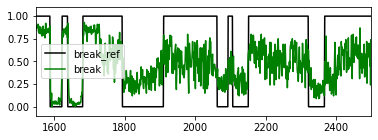

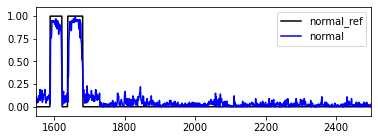

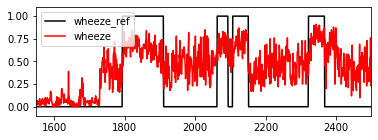

In [128]:
clf = joblib.load('saved_model/230730_RFC_larger_database_ICBHI_ref_max_cv_fold_10_train_with_9_without_scaler_2.joblib')

##################################### confusion matrix
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)

acc =accuracy_score(y_test,y_pred)
f1=f1_score(y_test,y_pred,average='weighted')

y_true = utils.to_categorical(y_test)

roc_auc = roc_auc_score(y_true, y_prob, multi_class='ovr')
cm = confusion_matrix(y_test, y_pred, normalize='true')

print('acc:', acc)
print('f1:', f1)
print('roc_auc:', roc_auc)
print(cm)

###################################### graph visuallization
y_prob_0 = y_prob[:,0]
y_prob_1 = y_prob[:,1]
y_prob_2 = y_prob[:,2]

y_true_0 = y_true[:,0]
y_true_1 = y_true[:,1]
y_true_2 = y_true[:,2]

view_start = 1550
view_end = 2500

plt.figure(figsize=(6,2))
# plt.figure()
plt.plot(y_true_0, label='break_ref', color='black')
plt.plot(y_prob_0, label='break', color='g')
plt.ylim(-0.1,1.1)
plt.xlim(view_start,view_end)
plt.legend()
plt.savefig('svg_images/Figure S5_break_RFC.svg')

plt.figure(figsize=(6,2))
plt.plot(y_true_1, label='normal_ref', color='black')
plt.plot(y_prob_1, label='normal', color='b')
plt.ylim(-0.1,1.1)
plt.xlim(view_start,view_end)
plt.legend()
plt.savefig('svg_images/Figure S5_normal_RFC.svg')

plt.figure(figsize=(6,2))
plt.plot(y_true_2, label='wheeze_ref', color='black')
plt.plot(y_prob_2, label='wheeze', color='r')
plt.ylim(-0.1,1.1)
plt.xlim(view_start,view_end)
plt.legend()
plt.savefig('svg_images/Figure S5_wheeze_RFC.svg')

### with k-fold, shuffle, scaler

acc: 0.8370186335403726
f1: 0.842056913078042
roc_auc: 0.952309017929985
[[0.85278569 0.00244002 0.1447743 ]
 [0.08768971 0.82630691 0.08600337]
 [0.0647482  0.1315519  0.8036999 ]]


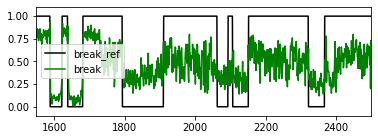

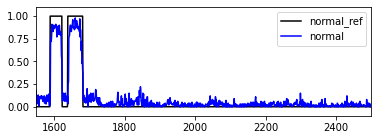

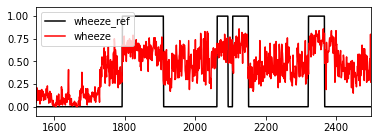

In [94]:
clf = joblib.load('saved_model/230730_RFC_larger_database_ICBHI_ref_max_cv_fold_10_train_with_9_with_shuffle_without_scaler.joblib')

##################################### confusion matrix
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)

acc =accuracy_score(y_test,y_pred)
f1=f1_score(y_test,y_pred,average='weighted')

y_true = utils.to_categorical(y_test)

roc_auc = roc_auc_score(y_true, y_prob, multi_class='ovr')
cm = confusion_matrix(y_test, y_pred, normalize='true')

print('acc:', acc)
print('f1:', f1)
print('roc_auc:', roc_auc)
print(cm)

###################################### graph visuallization
y_prob_0 = y_prob[:,0]
y_prob_1 = y_prob[:,1]
y_prob_2 = y_prob[:,2]

y_true_0 = y_true[:,0]
y_true_1 = y_true[:,1]
y_true_2 = y_true[:,2]

view_start = 1550
view_end = 2500

plt.figure(figsize=(6,2))
# plt.figure()
plt.plot(y_true_0, label='break_ref', color='black')
plt.plot(y_prob_0, label='break', color='g')
plt.ylim(-0.1,1.1)
plt.xlim(view_start,view_end)
plt.legend()
# plt.savefig('svg_images/figure6-1_break.svg')

plt.figure(figsize=(6,2))
plt.plot(y_true_1, label='normal_ref', color='black')
plt.plot(y_prob_1, label='normal', color='b')
plt.ylim(-0.1,1.1)
plt.xlim(view_start,view_end)
plt.legend()
# plt.savefig('svg_images/figure6-1_normal.svg')

plt.figure(figsize=(6,2))
plt.plot(y_true_2, label='wheeze_ref', color='black')
plt.plot(y_prob_2, label='wheeze', color='r')
plt.ylim(-0.1,1.1)
plt.xlim(view_start,view_end)
plt.legend()
# plt.savefig('svg_images/figure6-1_wheeze.svg')

### without k-fold, scaler 

acc: 0.8372670807453416
f1: 0.8421785447225325
roc_auc: 0.9530288238899
[[0.85359902 0.00325336 0.14314762]
 [0.08768971 0.82124789 0.09106239]
 [0.06988695 0.12435766 0.8057554 ]]


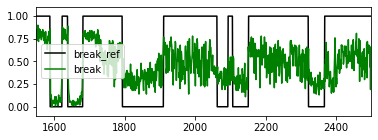

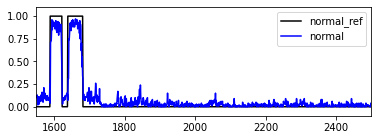

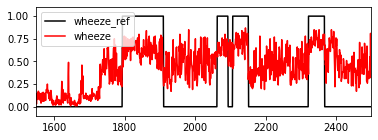

In [95]:
clf = joblib.load('saved_model/230730_RFC_larger_database_ICBHI_ref_max_no_scaler.joblib')

##################################### confusion matrix
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)

acc =accuracy_score(y_test,y_pred)
f1=f1_score(y_test,y_pred,average='weighted')

y_true = utils.to_categorical(y_test)

roc_auc = roc_auc_score(y_true, y_prob, multi_class='ovr')
cm = confusion_matrix(y_test, y_pred, normalize='true')

print('acc:', acc)
print('f1:', f1)
print('roc_auc:', roc_auc)
print(cm)

###################################### graph visuallization
y_prob_0 = y_prob[:,0]
y_prob_1 = y_prob[:,1]
y_prob_2 = y_prob[:,2]

y_true_0 = y_true[:,0]
y_true_1 = y_true[:,1]
y_true_2 = y_true[:,2]

view_start = 1550
view_end = 2500

plt.figure(figsize=(6,2))
# plt.figure()
plt.plot(y_true_0, label='break_ref', color='black')
plt.plot(y_prob_0, label='break', color='g')
plt.ylim(-0.1,1.1)
plt.xlim(view_start,view_end)
plt.legend()
# plt.savefig('svg_images/Figure S5_break_RFC.svg')

plt.figure(figsize=(6,2))
plt.plot(y_true_1, label='normal_ref', color='black')
plt.plot(y_prob_1, label='normal', color='b')
plt.ylim(-0.1,1.1)
plt.xlim(view_start,view_end)
plt.legend()
# plt.savefig('svg_images/Figure S5_normal_RFC.svg')

plt.figure(figsize=(6,2))
plt.plot(y_true_2, label='wheeze_ref', color='black')
plt.plot(y_prob_2, label='wheeze', color='r')
plt.ylim(-0.1,1.1)
plt.xlim(view_start,view_end)
plt.legend()
# plt.savefig('svg_images/Figure S5_wheeze_RFC.svg')

### without k-fold, with scaler 

acc: 0.8357763975155279
f1: 0.8409018850854336
roc_auc: 0.9533355171262423
[[0.84953233 0.00325336 0.14721431]
 [0.08600337 0.82630691 0.08768971]
 [0.0688592  0.12435766 0.80678314]]


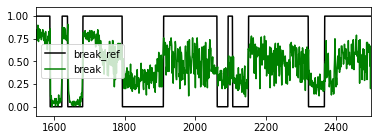

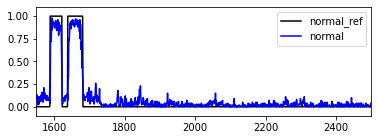

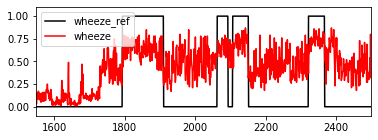

In [96]:
clf = joblib.load('saved_model/230730_RFC_larger_database_ICBHI_ref_max_with_scaler.joblib')

##################################### confusion matrix
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)

acc =accuracy_score(y_test,y_pred)
f1=f1_score(y_test,y_pred,average='weighted')

y_true = utils.to_categorical(y_test)

roc_auc = roc_auc_score(y_true, y_prob, multi_class='ovr')
cm = confusion_matrix(y_test, y_pred, normalize='true')

print('acc:', acc)
print('f1:', f1)
print('roc_auc:', roc_auc)
print(cm)

###################################### graph visuallization
y_prob_0 = y_prob[:,0]
y_prob_1 = y_prob[:,1]
y_prob_2 = y_prob[:,2]

y_true_0 = y_true[:,0]
y_true_1 = y_true[:,1]
y_true_2 = y_true[:,2]

view_start = 1550
view_end = 2500

plt.figure(figsize=(6,2))
# plt.figure()
plt.plot(y_true_0, label='break_ref', color='black')
plt.plot(y_prob_0, label='break', color='g')
plt.ylim(-0.1,1.1)
plt.xlim(view_start,view_end)
plt.legend()
# plt.savefig('svg_images/Figure S5_break_RFC.svg')

plt.figure(figsize=(6,2))
plt.plot(y_true_1, label='normal_ref', color='black')
plt.plot(y_prob_1, label='normal', color='b')
plt.ylim(-0.1,1.1)
plt.xlim(view_start,view_end)
plt.legend()
# plt.savefig('svg_images/Figure S5_normal_RFC.svg')

plt.figure(figsize=(6,2))
plt.plot(y_true_2, label='wheeze_ref', color='black')
plt.plot(y_prob_2, label='wheeze', color='r')
plt.ylim(-0.1,1.1)
plt.xlim(view_start,view_end)
plt.legend()
# plt.savefig('svg_images/Figure S5_wheeze_RFC.svg')

## Nearset Neighbors

### with k-fold, without scaler, fix sample rate error 

acc: 0.8233540372670808
f1: 0.8269936614885541
roc_auc: 0.9202266846916052
[[0.85237902 0.01220008 0.1354209 ]
 [0.10455312 0.84317032 0.05227656]
 [0.10894142 0.15313464 0.73792395]]


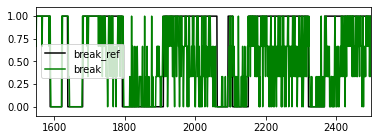

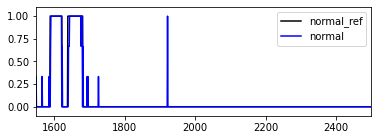

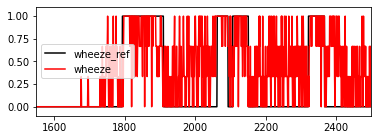

In [16]:
clf = joblib.load('saved_model/230730_KNN_larger_database_ICBHI_ref_max_cv_fold_10_train_with_9_without_scaler_fix_sample_rate_error.joblib')

##################################### confusion matrix
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)

acc =accuracy_score(y_test,y_pred)
f1=f1_score(y_test,y_pred,average='weighted')

y_true = utils.to_categorical(y_test)

roc_auc = roc_auc_score(y_true, y_prob, multi_class='ovr')
cm = confusion_matrix(y_test, y_pred, normalize='true')

print('acc:', acc)
print('f1:', f1)
print('roc_auc:', roc_auc)
print(cm)

###################################### graph visuallization
y_prob_0 = y_prob[:,0]
y_prob_1 = y_prob[:,1]
y_prob_2 = y_prob[:,2]

y_true_0 = y_true[:,0]
y_true_1 = y_true[:,1]
y_true_2 = y_true[:,2]

view_start = 1550
view_end = 2500

plt.figure(figsize=(6,2))
# plt.figure()
plt.plot(y_true_0, label='break_ref', color='black')
plt.plot(y_prob_0, label='break', color='g')
plt.ylim(-0.1,1.1)
plt.xlim(view_start,view_end)
plt.legend()
# plt.savefig('svg_images/figure6-1_break.svg')

plt.figure(figsize=(6,2))
plt.plot(y_true_1, label='normal_ref', color='black')
plt.plot(y_prob_1, label='normal', color='b')
plt.ylim(-0.1,1.1)
plt.xlim(view_start,view_end)
plt.legend()
# plt.savefig('svg_images/figure6-1_normal.svg')

plt.figure(figsize=(6,2))
plt.plot(y_true_2, label='wheeze_ref', color='black')
plt.plot(y_prob_2, label='wheeze', color='r')
plt.ylim(-0.1,1.1)
plt.xlim(view_start,view_end)
plt.legend()
# plt.savefig('svg_images/figure6-1_wheeze.svg')

### with k-fold, scaler

acc: 0.7642236024844721
f1: 0.73753981842823
roc_auc: 0.7864435686152825
[[0.97763318 0.00732005 0.01504677]
 [0.3693086  0.53625632 0.09443508]
 [0.42857143 0.20760534 0.36382323]]


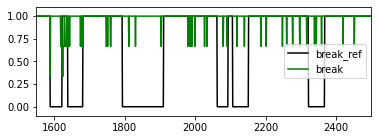

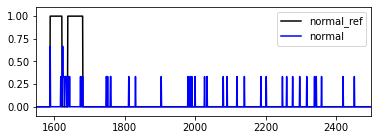

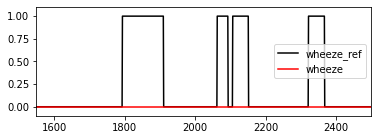

In [97]:
clf = joblib.load('saved_model/230730_KNN_larger_database_ICBHI_ref_max_cv_fold_10_train_with_9_with_scaler.joblib')

##################################### confusion matrix
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)

acc =accuracy_score(y_test,y_pred)
f1=f1_score(y_test,y_pred,average='weighted')

y_true = utils.to_categorical(y_test)

roc_auc = roc_auc_score(y_true, y_prob, multi_class='ovr')
cm = confusion_matrix(y_test, y_pred, normalize='true')

print('acc:', acc)
print('f1:', f1)
print('roc_auc:', roc_auc)
print(cm)

###################################### graph visuallization
y_prob_0 = y_prob[:,0]
y_prob_1 = y_prob[:,1]
y_prob_2 = y_prob[:,2]

y_true_0 = y_true[:,0]
y_true_1 = y_true[:,1]
y_true_2 = y_true[:,2]

view_start = 1550
view_end = 2500

plt.figure(figsize=(6,2))
# plt.figure()
plt.plot(y_true_0, label='break_ref', color='black')
plt.plot(y_prob_0, label='break', color='g')
plt.ylim(-0.1,1.1)
plt.xlim(view_start,view_end)
plt.legend()
# plt.savefig('svg_images/figure6-1_break.svg')

plt.figure(figsize=(6,2))
plt.plot(y_true_1, label='normal_ref', color='black')
plt.plot(y_prob_1, label='normal', color='b')
plt.ylim(-0.1,1.1)
plt.xlim(view_start,view_end)
plt.legend()
# plt.savefig('svg_images/figure6-1_normal.svg')

plt.figure(figsize=(6,2))
plt.plot(y_true_2, label='wheeze_ref', color='black')
plt.plot(y_prob_2, label='wheeze', color='r')
plt.ylim(-0.1,1.1)
plt.xlim(view_start,view_end)
plt.legend()
# plt.savefig('svg_images/figure6-1_wheeze.svg')

### with k-fold, without scaler 

acc: 0.826583850931677
f1: 0.8299577178725351
roc_auc: 0.9190353886930606
[[0.85766572 0.00732005 0.13501423]
 [0.10455312 0.84317032 0.05227656]
 [0.11305242 0.14902364 0.73792395]]


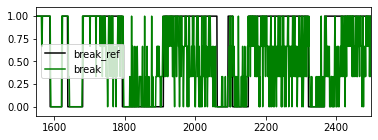

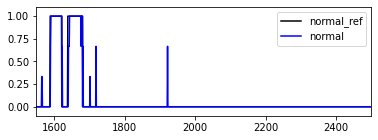

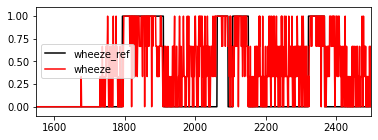

In [113]:
clf = joblib.load('saved_model/230730_KNN_larger_database_ICBHI_ref_max_cv_fold_10_train_with_9_without_scaler.joblib')

##################################### confusion matrix
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)

acc =accuracy_score(y_test,y_pred)
f1=f1_score(y_test,y_pred,average='weighted')

y_true = utils.to_categorical(y_test)

roc_auc = roc_auc_score(y_true, y_prob, multi_class='ovr')
cm = confusion_matrix(y_test, y_pred, normalize='true')

print('acc:', acc)
print('f1:', f1)
print('roc_auc:', roc_auc)
print(cm)

###################################### graph visuallization
y_prob_0 = y_prob[:,0]
y_prob_1 = y_prob[:,1]
y_prob_2 = y_prob[:,2]

y_true_0 = y_true[:,0]
y_true_1 = y_true[:,1]
y_true_2 = y_true[:,2]

view_start = 1550
view_end = 2500

plt.figure(figsize=(6,2))
# plt.figure()
plt.plot(y_true_0, label='break_ref', color='black')
plt.plot(y_prob_0, label='break', color='g')
plt.ylim(-0.1,1.1)
plt.xlim(view_start,view_end)
plt.legend()
# plt.savefig('svg_images/figure6-1_break.svg')

plt.figure(figsize=(6,2))
plt.plot(y_true_1, label='normal_ref', color='black')
plt.plot(y_prob_1, label='normal', color='b')
plt.ylim(-0.1,1.1)
plt.xlim(view_start,view_end)
plt.legend()
# plt.savefig('svg_images/figure6-1_normal.svg')

plt.figure(figsize=(6,2))
plt.plot(y_true_2, label='wheeze_ref', color='black')
plt.plot(y_prob_2, label='wheeze', color='r')
plt.ylim(-0.1,1.1)
plt.xlim(view_start,view_end)
plt.legend()
# plt.savefig('svg_images/figure6-1_wheeze.svg')

### without k-fold, with scaler

acc: 0.7607453416149068
f1: 0.7331757895074731
roc_auc: 0.7802691847024038
[[0.97681985 0.00772672 0.01545344]
 [0.37099494 0.52613828 0.10286678]
 [0.44295992 0.19938335 0.35765673]]


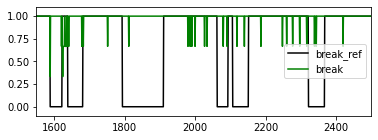

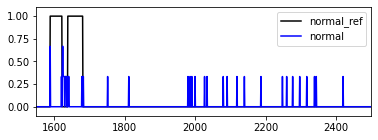

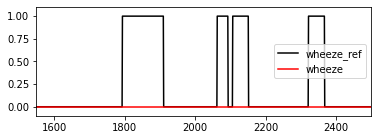

In [98]:
clf = joblib.load('saved_model/230730_KNN_larger_database_ICBHI_ref_max_with_scaler.joblib')

##################################### confusion matrix
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)

acc =accuracy_score(y_test,y_pred)
f1=f1_score(y_test,y_pred,average='weighted')

y_true = utils.to_categorical(y_test)

roc_auc = roc_auc_score(y_true, y_prob, multi_class='ovr')
cm = confusion_matrix(y_test, y_pred, normalize='true')

print('acc:', acc)
print('f1:', f1)
print('roc_auc:', roc_auc)
print(cm)

###################################### graph visuallization
y_prob_0 = y_prob[:,0]
y_prob_1 = y_prob[:,1]
y_prob_2 = y_prob[:,2]

y_true_0 = y_true[:,0]
y_true_1 = y_true[:,1]
y_true_2 = y_true[:,2]

view_start = 1550
view_end = 2500

plt.figure(figsize=(6,2))
# plt.figure()
plt.plot(y_true_0, label='break_ref', color='black')
plt.plot(y_prob_0, label='break', color='g')
plt.ylim(-0.1,1.1)
plt.xlim(view_start,view_end)
plt.legend()
# plt.savefig('svg_images/figure6-1_break.svg')

plt.figure(figsize=(6,2))
plt.plot(y_true_1, label='normal_ref', color='black')
plt.plot(y_prob_1, label='normal', color='b')
plt.ylim(-0.1,1.1)
plt.xlim(view_start,view_end)
plt.legend()
# plt.savefig('svg_images/figure6-1_normal.svg')

plt.figure(figsize=(6,2))
plt.plot(y_true_2, label='wheeze_ref', color='black')
plt.plot(y_prob_2, label='wheeze', color='r')
plt.ylim(-0.1,1.1)
plt.xlim(view_start,view_end)
plt.legend()
# plt.savefig('svg_images/figure6-1_wheeze.svg')

### without k-fold, scaler

acc: 0.8260869565217391
f1: 0.8294645570249439
roc_auc: 0.9202688934836653
[[0.85725905 0.00732005 0.1354209 ]
 [0.10455312 0.84317032 0.05227656]
 [0.11408016 0.14902364 0.7368962 ]]


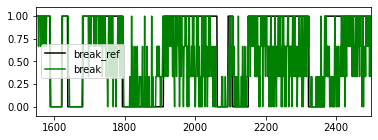

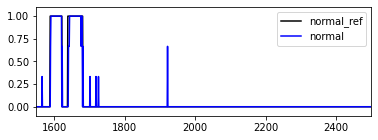

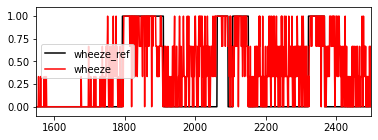

In [99]:
clf = joblib.load('saved_model/230730_KNN_larger_database_ICBHI_ref_max_without_scaler.joblib')

##################################### confusion matrix
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)

acc =accuracy_score(y_test,y_pred)
f1=f1_score(y_test,y_pred,average='weighted')

y_true = utils.to_categorical(y_test)

roc_auc = roc_auc_score(y_true, y_prob, multi_class='ovr')
cm = confusion_matrix(y_test, y_pred, normalize='true')

print('acc:', acc)
print('f1:', f1)
print('roc_auc:', roc_auc)
print(cm)

###################################### graph visuallization
y_prob_0 = y_prob[:,0]
y_prob_1 = y_prob[:,1]
y_prob_2 = y_prob[:,2]

y_true_0 = y_true[:,0]
y_true_1 = y_true[:,1]
y_true_2 = y_true[:,2]

view_start = 1550
view_end = 2500

plt.figure(figsize=(6,2))
# plt.figure()
plt.plot(y_true_0, label='break_ref', color='black')
plt.plot(y_prob_0, label='break', color='g')
plt.ylim(-0.1,1.1)
plt.xlim(view_start,view_end)
plt.legend()
plt.savefig('svg_images/Figure S5_break_KNN.svg')

plt.figure(figsize=(6,2))
plt.plot(y_true_1, label='normal_ref', color='black')
plt.plot(y_prob_1, label='normal', color='b')
plt.ylim(-0.1,1.1)
plt.xlim(view_start,view_end)
plt.legend()
plt.savefig('svg_images/Figure S5_normal_KNN.svg')

plt.figure(figsize=(6,2))
plt.plot(y_true_2, label='wheeze_ref', color='black')
plt.plot(y_prob_2, label='wheeze', color='r')
plt.ylim(-0.1,1.1)
plt.xlim(view_start,view_end)
plt.legend()
plt.savefig('svg_images/Figure S5_wheeze_KNN.svg')

## Multi Layer Perceptron 

### with k-fold, without scaler, fix sample rate error 

acc: 0.8683229813664596
f1: 0.8704820265679196
roc_auc: 0.9490209603170922
[[0.91541277 0.01952013 0.0650671 ]
 [0.03541315 0.70320405 0.2613828 ]
 [0.06372045 0.08633094 0.84994861]]


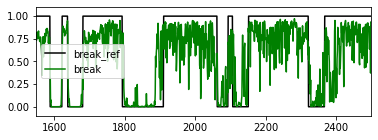

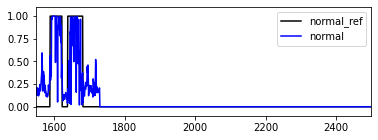

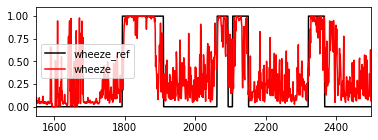

In [17]:
clf = joblib.load('saved_model/230730_MLP_larger_database_ICBHI_ref_max_cv_fold_10_train_with_9_without_scaler_fix_sample_rate_error.joblib')

##################################### confusion matrix
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)

acc =accuracy_score(y_test,y_pred)
f1=f1_score(y_test,y_pred,average='weighted')

y_true = utils.to_categorical(y_test)

roc_auc = roc_auc_score(y_true, y_prob, multi_class='ovr')
cm = confusion_matrix(y_test, y_pred, normalize='true')

print('acc:', acc)
print('f1:', f1)
print('roc_auc:', roc_auc)
print(cm)

###################################### graph visuallization
y_prob_0 = y_prob[:,0]
y_prob_1 = y_prob[:,1]
y_prob_2 = y_prob[:,2]

y_true_0 = y_true[:,0]
y_true_1 = y_true[:,1]
y_true_2 = y_true[:,2]

view_start = 1550
view_end = 2500

plt.figure(figsize=(6,2))
# plt.figure()
plt.plot(y_true_0, label='break_ref', color='black')
plt.plot(y_prob_0, label='break', color='g')
plt.ylim(-0.1,1.1)
plt.xlim(view_start,view_end)
plt.legend()
# plt.savefig('svg_images/figure6-1_break.svg')

plt.figure(figsize=(6,2))
plt.plot(y_true_1, label='normal_ref', color='black')
plt.plot(y_prob_1, label='normal', color='b')
plt.ylim(-0.1,1.1)
plt.xlim(view_start,view_end)
plt.legend()
# plt.savefig('svg_images/figure6-1_normal.svg')

plt.figure(figsize=(6,2))
plt.plot(y_true_2, label='wheeze_ref', color='black')
plt.plot(y_prob_2, label='wheeze', color='r')
plt.ylim(-0.1,1.1)
plt.xlim(view_start,view_end)
plt.legend()
# plt.savefig('svg_images/figure6-1_wheeze.svg')

### with k-fold, scaler 

acc: 0.7741614906832298
f1: 0.7561563232858209
roc_auc: 0.8383847354529177
[[0.96990647 0.01098007 0.01911346]
 [0.19561551 0.46711636 0.33726813]
 [0.37101747 0.16238438 0.46659815]]


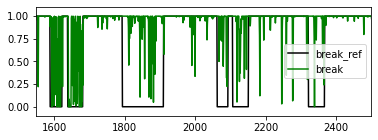

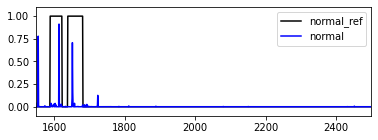

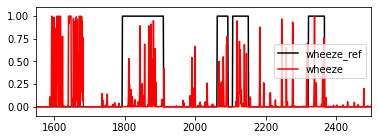

In [100]:
clf = joblib.load('saved_model/230730_MLP_larger_database_ICBHI_ref_max_cv_fold_10_train_with_9_with_scaler.joblib')

##################################### confusion matrix
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)

acc =accuracy_score(y_test,y_pred)
f1=f1_score(y_test,y_pred,average='weighted')

y_true = utils.to_categorical(y_test)

roc_auc = roc_auc_score(y_true, y_prob, multi_class='ovr')
cm = confusion_matrix(y_test, y_pred, normalize='true')

print('acc:', acc)
print('f1:', f1)
print('roc_auc:', roc_auc)
print(cm)

###################################### graph visuallization
y_prob_0 = y_prob[:,0]
y_prob_1 = y_prob[:,1]
y_prob_2 = y_prob[:,2]

y_true_0 = y_true[:,0]
y_true_1 = y_true[:,1]
y_true_2 = y_true[:,2]

view_start = 1550
view_end = 2500

plt.figure(figsize=(6,2))
# plt.figure()
plt.plot(y_true_0, label='break_ref', color='black')
plt.plot(y_prob_0, label='break', color='g')
plt.ylim(-0.1,1.1)
plt.xlim(view_start,view_end)
plt.legend()
# plt.savefig('svg_images/figure6-1_break.svg')

plt.figure(figsize=(6,2))
plt.plot(y_true_1, label='normal_ref', color='black')
plt.plot(y_prob_1, label='normal', color='b')
plt.ylim(-0.1,1.1)
plt.xlim(view_start,view_end)
plt.legend()
# plt.savefig('svg_images/figure6-1_normal.svg')

plt.figure(figsize=(6,2))
plt.plot(y_true_2, label='wheeze_ref', color='black')
plt.plot(y_prob_2, label='wheeze', color='r')
plt.ylim(-0.1,1.1)
plt.xlim(view_start,view_end)
plt.legend()
# plt.savefig('svg_images/figure6-1_wheeze.svg')

### with k-fold, without scaler 

acc: 0.7634782608695653
f1: 0.7753987825947355
roc_auc: 0.9318727988695117
[[0.74420496 0.00203335 0.25376169]
 [0.10455312 0.73693086 0.15851602]
 [0.08735868 0.08427544 0.82836588]]


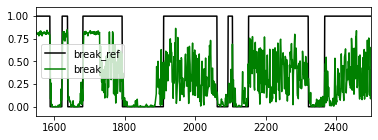

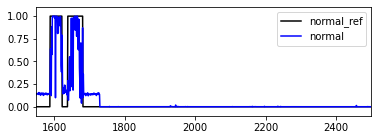

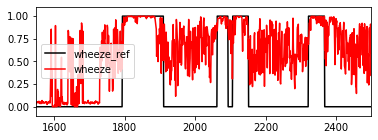

In [129]:
clf = joblib.load('saved_model/230730_MLP_larger_database_ICBHI_ref_max_cv_fold_10_train_with_9_without_scaler.joblib')

##################################### confusion matrix
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)

acc =accuracy_score(y_test,y_pred)
f1=f1_score(y_test,y_pred,average='weighted')

y_true = utils.to_categorical(y_test)

roc_auc = roc_auc_score(y_true, y_prob, multi_class='ovr')
cm = confusion_matrix(y_test, y_pred, normalize='true')

print('acc:', acc)
print('f1:', f1)
print('roc_auc:', roc_auc)
print(cm)

###################################### graph visuallization
y_prob_0 = y_prob[:,0]
y_prob_1 = y_prob[:,1]
y_prob_2 = y_prob[:,2]

y_true_0 = y_true[:,0]
y_true_1 = y_true[:,1]
y_true_2 = y_true[:,2]

view_start = 1550
view_end = 2500

plt.figure(figsize=(6,2))
# plt.figure()
plt.plot(y_true_0, label='break_ref', color='black')
plt.plot(y_prob_0, label='break', color='g')
plt.ylim(-0.1,1.1)
plt.xlim(view_start,view_end)
plt.legend()
plt.savefig('svg_images/figure S5_break_MLP.svg')

plt.figure(figsize=(6,2))
plt.plot(y_true_1, label='normal_ref', color='black')
plt.plot(y_prob_1, label='normal', color='b')
plt.ylim(-0.1,1.1)
plt.xlim(view_start,view_end)
plt.legend()
plt.savefig('svg_images/figure S5_normal_MLP.svg')

plt.figure(figsize=(6,2))
plt.plot(y_true_2, label='wheeze_ref', color='black')
plt.plot(y_prob_2, label='wheeze', color='r')
plt.ylim(-0.1,1.1)
plt.xlim(view_start,view_end)
plt.legend()
plt.savefig('svg_images/figure S5_wheeze_MLP.svg')

### without k-fold, scaler 

acc: 0.7669565217391304
f1: 0.7684368659991588
roc_auc: 0.9213942807368825
[[0.83326556 0.         0.16673444]
 [0.12310287 0.37605396 0.50084317]
 [0.08633094 0.07605344 0.83761562]]


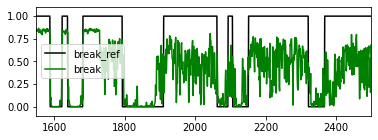

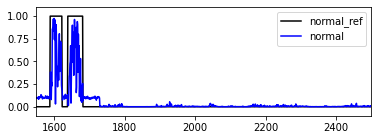

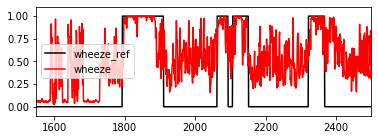

In [101]:
clf = joblib.load('saved_model/230730_MLP_larger_database_ICBHI_ref_max_without_scaler.joblib')

##################################### confusion matrix
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)

acc =accuracy_score(y_test,y_pred)
f1=f1_score(y_test,y_pred,average='weighted')

y_true = utils.to_categorical(y_test)

roc_auc = roc_auc_score(y_true, y_prob, multi_class='ovr')
cm = confusion_matrix(y_test, y_pred, normalize='true')

print('acc:', acc)
print('f1:', f1)
print('roc_auc:', roc_auc)
print(cm)

###################################### graph visuallization
y_prob_0 = y_prob[:,0]
y_prob_1 = y_prob[:,1]
y_prob_2 = y_prob[:,2]

y_true_0 = y_true[:,0]
y_true_1 = y_true[:,1]
y_true_2 = y_true[:,2]

view_start = 1550
view_end = 2500

plt.figure(figsize=(6,2))
# plt.figure()
plt.plot(y_true_0, label='break_ref', color='black')
plt.plot(y_prob_0, label='break', color='g')
plt.ylim(-0.1,1.1)
plt.xlim(view_start,view_end)
plt.legend()
# plt.savefig('svg_images/figure S5_break_MLP.svg')

plt.figure(figsize=(6,2))
plt.plot(y_true_1, label='normal_ref', color='black')
plt.plot(y_prob_1, label='normal', color='b')
plt.ylim(-0.1,1.1)
plt.xlim(view_start,view_end)
plt.legend()
# plt.savefig('svg_images/figure S5_normal_MLP.svg')

plt.figure(figsize=(6,2))
plt.plot(y_true_2, label='wheeze_ref', color='black')
plt.plot(y_prob_2, label='wheeze', color='r')
plt.ylim(-0.1,1.1)
plt.xlim(view_start,view_end)
plt.legend()
# plt.savefig('svg_images/figure S5_wheeze_MLP.svg')

### without k-fold, with scaler 

acc: 0.6581366459627329
f1: 0.6897669924392718
roc_auc: 0.8452456502867675
[[0.71492477 0.27206181 0.01301342]
 [0.02866779 0.72175379 0.24957841]
 [0.15724563 0.36690647 0.47584789]]


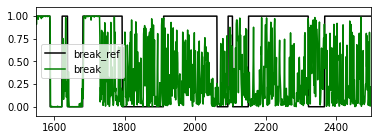

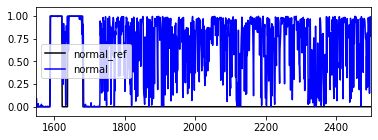

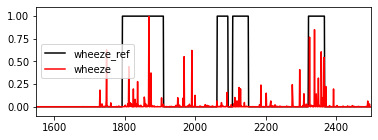

In [102]:
clf = joblib.load('saved_model/230730_MLP_larger_database_ICBHI_ref_max_with_scaler.joblib')

##################################### confusion matrix
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)

acc =accuracy_score(y_test,y_pred)
f1=f1_score(y_test,y_pred,average='weighted')

y_true = utils.to_categorical(y_test)

roc_auc = roc_auc_score(y_true, y_prob, multi_class='ovr')
cm = confusion_matrix(y_test, y_pred, normalize='true')

print('acc:', acc)
print('f1:', f1)
print('roc_auc:', roc_auc)
print(cm)

###################################### graph visuallization
y_prob_0 = y_prob[:,0]
y_prob_1 = y_prob[:,1]
y_prob_2 = y_prob[:,2]

y_true_0 = y_true[:,0]
y_true_1 = y_true[:,1]
y_true_2 = y_true[:,2]

view_start = 1550
view_end = 2500

plt.figure(figsize=(6,2))
# plt.figure()
plt.plot(y_true_0, label='break_ref', color='black')
plt.plot(y_prob_0, label='break', color='g')
plt.ylim(-0.1,1.1)
plt.xlim(view_start,view_end)
plt.legend()

plt.figure(figsize=(6,2))
plt.plot(y_true_1, label='normal_ref', color='black')
plt.plot(y_prob_1, label='normal', color='b')
plt.ylim(-0.1,1.1)
plt.xlim(view_start,view_end)
plt.legend()

plt.figure(figsize=(6,2))
plt.plot(y_true_2, label='wheeze_ref', color='black')
plt.plot(y_prob_2, label='wheeze', color='r')
plt.ylim(-0.1,1.1)
plt.xlim(view_start,view_end)
plt.legend()

## 1dCNN bLSTM 

In [15]:
n_mels = 128
frame_sec = 0.025
step_sec = 0.01
label_ratio = 1

X_test, y_test = make_validation_dataset_keras(val_file_path, val_ordered_file_list, n_mels, frame_sec, step_sec, label_ratio)

### with k-fold, wihtout scaler 

acc: 0.9048447204968945
f1: 0.9039487974709863
roc_auc: 0.9725174799035443
[[0.9548597  0.00284669 0.04229362]
 [0.11804384 0.84317032 0.03878583]
 [0.12024666 0.06372045 0.81603289]]
[[2348    7  104]
 [  70  500   23]
 [ 117   62  794]]


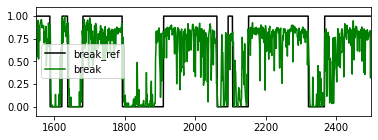

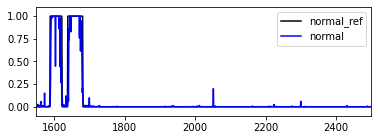

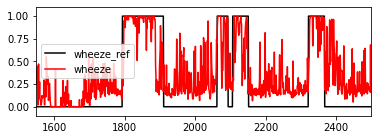

In [16]:
model = load_model('saved_model/230730_1dCNN_bLSTM_larger_dataset_with_ICBHI_ref_npmax_k_fold_10_train_with_9_best_acc')

##################################### confusion matrix
y_pred = model.predict(X_test)
acc =accuracy_score(y_test.argmax(axis=1),y_pred.argmax(axis=1))
f1=f1_score(y_test.argmax(axis=1),y_pred.argmax(axis=1),average='weighted')

roc_auc = roc_auc_score(y_test, y_pred, multi_class='ovr')
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1), normalize='true')
cm2 = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

print('acc:', acc)
print('f1:', f1)
print('roc_auc:', roc_auc)
print(cm)
print(cm2)

###################################### graph visuallization
y_pred_0 = y_pred[:,0]
y_pred_1 = y_pred[:,1]
y_pred_2 = y_pred[:,2]

y_test_0 = y_test[:,0]
y_test_1 = y_test[:,1]
y_test_2 = y_test[:,2]

view_start = 1550
view_end = 2500

# x = np.arange(len(y_test_0))

plt.figure(figsize=(6,2))
plt.plot(y_test_0, label='break_ref', color='black')
plt.plot(y_pred_0, label='break', color='g')
plt.ylim(-0.1,1.1)
plt.xlim(view_start,view_end)
plt.legend()
plt.savefig('svg_images/Figure 4_break_1dCNN_bLSTM.svg')

plt.figure(figsize=(6,2))
plt.plot(y_test_1, label='normal_ref', color='black')
plt.plot(y_pred_1, label='normal', color='b')
plt.ylim(-0.1,1.1)
plt.xlim(view_start,view_end)
plt.legend()
plt.savefig('svg_images/Figure 4_normal_1dCNN_bLSTM.svg')

plt.figure(figsize=(6,2))
plt.plot(y_test_2, label='wheeze_ref', color='black')
plt.plot(y_pred_2, label='wheeze', color='r')
plt.ylim(-0.1,1.1)
plt.xlim(view_start,view_end)
plt.legend()
plt.savefig('svg_images/Figure 4_wheeze_1dCNN_bLSTM.svg')

### without k-fold, scaler 

acc: 0.8675776397515528
f1: 0.8716075069265067
roc_auc: 0.9708689022613854
[[0.86376576 0.00447336 0.13176088]
 [0.07082631 0.8381113  0.09106239]
 [0.05858171 0.04624872 0.89516958]]


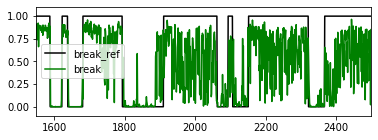

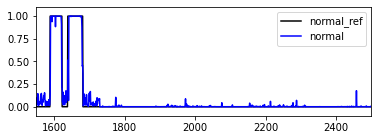

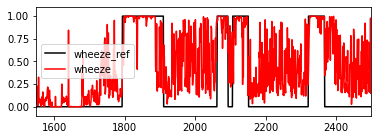

In [17]:
model = load_model('saved_model/230730_1dCNN_bLSTM_larger_dataset_with_ICBHI_ref_npmax')

##################################### confusion matrix
y_pred = model.predict(X_test)
acc =accuracy_score(y_test.argmax(axis=1),y_pred.argmax(axis=1))
f1=f1_score(y_test.argmax(axis=1),y_pred.argmax(axis=1),average='weighted')

roc_auc = roc_auc_score(y_test, y_pred, multi_class='ovr')
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1), normalize='true')

print('acc:', acc)
print('f1:', f1)
print('roc_auc:', roc_auc)
print(cm)

###################################### graph visuallization
y_pred_0 = y_pred[:,0]
y_pred_1 = y_pred[:,1]
y_pred_2 = y_pred[:,2]

y_test_0 = y_test[:,0]
y_test_1 = y_test[:,1]
y_test_2 = y_test[:,2]

view_start = 1550
view_end = 2500

# x = np.arange(len(y_test_0))

plt.figure(figsize=(6,2))
plt.plot(y_test_0, label='break_ref', color='black')
plt.plot(y_pred_0, label='break', color='g')
plt.ylim(-0.1,1.1)
plt.xlim(view_start,view_end)
plt.legend()
# plt.savefig('svg_images/figure6-2_break.svg')

plt.figure(figsize=(6,2))
plt.plot(y_test_1, label='normal_ref', color='black')
plt.plot(y_pred_1, label='normal', color='b')
plt.ylim(-0.1,1.1)
plt.xlim(view_start,view_end)
plt.legend()
# plt.savefig('svg_images/figure6-2_normal.svg')

plt.figure(figsize=(6,2))
plt.plot(y_test_2, label='wheeze_ref', color='black')
plt.plot(y_pred_2, label='wheeze', color='r')
plt.ylim(-0.1,1.1)
plt.xlim(view_start,view_end)
plt.legend()
# plt.savefig('svg_images/figure6-2_wheeze.svg')

### with k-fold, without scaler, fix sample rate error

acc: 0.9195031055900621
f1: 0.919374897622007
roc_auc: 0.9771027832115952
[[0.95526637 0.00732005 0.03741358]
 [0.06913997 0.87521079 0.05564924]
 [0.08221994 0.06166495 0.85611511]]


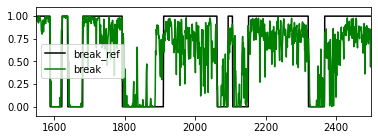

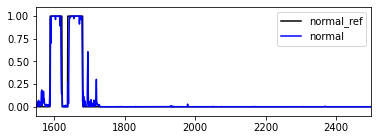

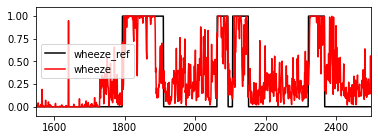

In [18]:
model = load_model('saved_model/230730_1dCNN_bLSTM_larger_dataset_with_ICBHI_ref_npmax_k_fold_10_train_with_9_best_acc_fix_sample_rate_error')

##################################### confusion matrix
y_pred = model.predict(X_test)
acc =accuracy_score(y_test.argmax(axis=1),y_pred.argmax(axis=1))
f1=f1_score(y_test.argmax(axis=1),y_pred.argmax(axis=1),average='weighted')

roc_auc = roc_auc_score(y_test, y_pred, multi_class='ovr')
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1), normalize='true')

print('acc:', acc)
print('f1:', f1)
print('roc_auc:', roc_auc)
print(cm)

###################################### graph visuallization
y_pred_0 = y_pred[:,0]
y_pred_1 = y_pred[:,1]
y_pred_2 = y_pred[:,2]

y_test_0 = y_test[:,0]
y_test_1 = y_test[:,1]
y_test_2 = y_test[:,2]

view_start = 1550
view_end = 2500

# x = np.arange(len(y_test_0))

plt.figure(figsize=(6,2))
plt.plot(y_test_0, label='break_ref', color='black')
plt.plot(y_pred_0, label='break', color='g')
plt.ylim(-0.1,1.1)
plt.xlim(view_start,view_end)
plt.legend()
# plt.savefig('svg_images/figure6-2_break.svg')

plt.figure(figsize=(6,2))
plt.plot(y_test_1, label='normal_ref', color='black')
plt.plot(y_pred_1, label='normal', color='b')
plt.ylim(-0.1,1.1)
plt.xlim(view_start,view_end)
plt.legend()
# plt.savefig('svg_images/figure6-2_normal.svg')

plt.figure(figsize=(6,2))
plt.plot(y_test_2, label='wheeze_ref', color='black')
plt.plot(y_pred_2, label='wheeze', color='r')
plt.ylim(-0.1,1.1)
plt.xlim(view_start,view_end)
plt.legend()
# plt.savefig('svg_images/figure6-2_wheeze.svg')

### Test with noisy data

In [19]:
n_mels = 128
frame_sec = 0.025
step_sec = 0.01
label_ratio = 1

test_file_path= 'data/validation_noise'
test_file_list = os.listdir(test_file_path)
ordered_test_file_list = natsort.natsorted(test_file_list)
ordered_test_file_list

['validation_combined_audio.wav',
 'validation_combined_audio_hospital_background.wav',
 'validation_combined_audio_white_noise_0.02.wav']

In [20]:
n_mels = 128
frame_sec = 0.025
step_sec = 0.01
label_ratio = 1

X_test, y_test = make_validation_dataset_keras(val_file_path, val_ordered_file_list, n_mels, frame_sec, step_sec, label_ratio)

In [21]:
index = 0
sample_rate = librosa.get_samplerate(test_file_path + '/' + ordered_test_file_list[index])
t1, t1_sr = librosa.load(test_file_path + '/' + ordered_test_file_list[index], sr = sample_rate)
# t1 = t1[250000:]
t1_nr = nr.reduce_noise(t1, sr = sample_rate, n_std_thresh_stationary=0.1, stationary=True)
t1_nr2 = nr.reduce_noise(t1, sr = sample_rate)
# t1_label = pd.read_csv(test_file_path + '/' + ordered_test_file_list[index-1], sep='\t', header=None)

index = 1
sample_rate = librosa.get_samplerate(test_file_path + '/' + ordered_test_file_list[index])
t2, t2_sr = librosa.load(test_file_path + '/' + ordered_test_file_list[index], sr = sample_rate)
# t2 = t2[250000:]
t2_nr = nr.reduce_noise(t2, sr = sample_rate, n_std_thresh_stationary=0.1, stationary=True)
t2_nr2 = nr.reduce_noise(t2, sr = sample_rate)
# t2_label = pd.read_csv(test_file_path + '/' + ordered_test_file_list[index-1], sep='\t', header=None)

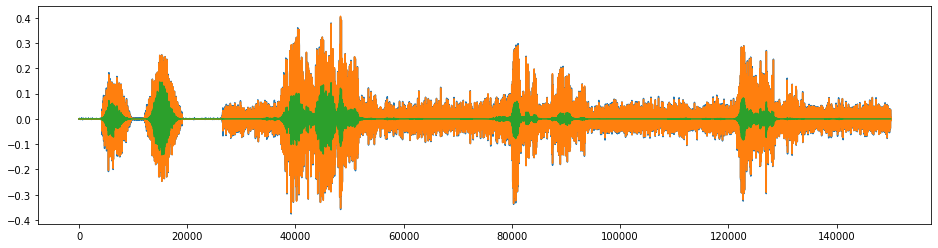

In [22]:
plt.figure(figsize=(16,4))
plt.plot(t1[250000:400000])
plt.plot(t1_nr[250000:400000])
plt.plot(t1_nr2[250000:400000])

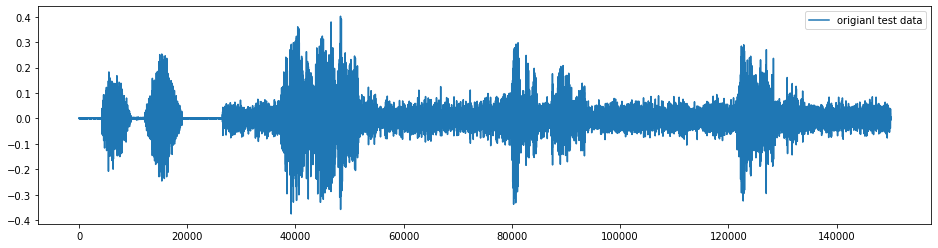

In [23]:
plt.figure(figsize=(16,4))
plt.plot(t1[250000:400000], label = 'origianl test data')
plt.legend()
plt.savefig('svg_images/Figure S6_raw_audio_signal.svg')

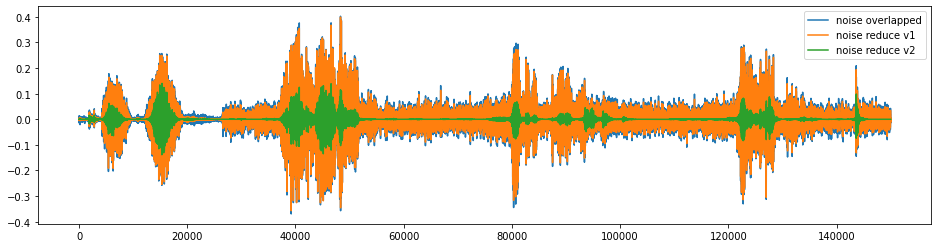

In [24]:
plt.figure(figsize=(16,4))
plt.plot(t2[250000:400000], label = 'noise overlapped')
plt.plot(t2_nr[250000:400000], label = 'noise reduce v1')
plt.plot(t2_nr2[250000:400000], label = 'noise reduce v2')
plt.legend()
plt.savefig('svg_images/Figure S6_audio_signal.svg')

In [25]:
Audio(t1[250000:400000], rate = sample_rate)

In [26]:
Audio(t1_nr[250000:400000], rate = sample_rate)

In [27]:
Audio(t1_nr2[250000:400000], rate = sample_rate)

In [28]:
Audio(t2[250000:400000], rate = sample_rate)

In [29]:
Audio(t2_nr[250000:400000], rate = sample_rate)

In [30]:
Audio(t2_nr2[250000:400000], rate = sample_rate)

In [32]:
t1_x = make_test_dataset_keras_without_label(t1, n_mels, frame_sec, step_sec, sample_rate)
t2_x = make_test_dataset_keras_without_label(t2, n_mels, frame_sec, step_sec, sample_rate)
# t3_x = make_test_dataset_keras_without_label(t3, n_mels, frame_sec, step_sec, sample_rate)

t1_x_nr = make_test_dataset_keras_without_label(t1_nr, n_mels, frame_sec, step_sec, sample_rate)
t2_x_nr = make_test_dataset_keras_without_label(t2_nr, n_mels, frame_sec, step_sec, sample_rate)

t1_x_nr2 = make_test_dataset_keras_without_label(t1_nr2, n_mels, frame_sec, step_sec, sample_rate)
t2_x_nr2 = make_test_dataset_keras_without_label(t2_nr2, n_mels, frame_sec, step_sec, sample_rate)
# t3_x_nr = make_test_dataset_keras_without_label(t3_nr, n_mels, frame_sec, step_sec, sample_rate)

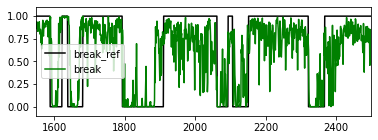

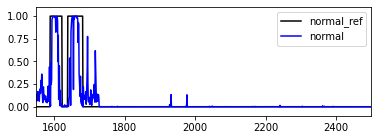

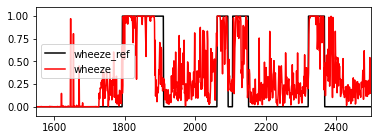

In [33]:
model = load_model('saved_model/230730_1dCNN_bLSTM_larger_dataset_with_ICBHI_ref_npmax_k_fold_10_train_with_9_best_acc_fix_sample_rate_error')

y_pred = model.predict(t1_x)

###################################### graph visuallization
y_pred_0 = y_pred[:,0]
y_pred_1 = y_pred[:,1]
y_pred_2 = y_pred[:,2]

y_test_0 = y_test[:,0]
y_test_1 = y_test[:,1]
y_test_2 = y_test[:,2]

view_start = 1550
view_end = 2500

# x = np.arange(len(y_test_0))

plt.figure(figsize=(6,2))
plt.plot(y_test_0, label='break_ref', color='black')
plt.plot(y_pred_0, label='break', color='g')
plt.ylim(-0.1,1.1)
plt.xlim(view_start,view_end)
plt.legend()
# plt.savefig('svg_images/figure6-2_break.svg')

plt.figure(figsize=(6,2))
plt.plot(y_test_1, label='normal_ref', color='black')
plt.plot(y_pred_1, label='normal', color='b')
plt.ylim(-0.1,1.1)
plt.xlim(view_start,view_end)
plt.legend()
# plt.savefig('svg_images/figure6-2_normal.svg')

plt.figure(figsize=(6,2))
plt.plot(y_test_2, label='wheeze_ref', color='black')
plt.plot(y_pred_2, label='wheeze', color='r')
plt.ylim(-0.1,1.1)
plt.xlim(view_start,view_end)
plt.legend()
# plt.savefig('svg_images/figure6-2_wheeze.svg')

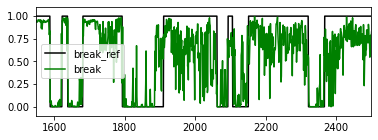

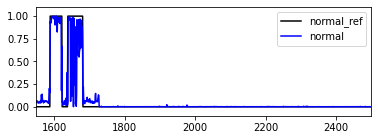

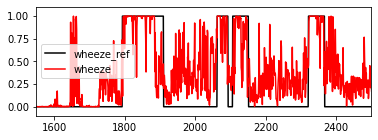

In [34]:
y_pred = model.predict(t1_x_nr)

###################################### graph visuallization
y_pred_0 = y_pred[:,0]
y_pred_1 = y_pred[:,1]
y_pred_2 = y_pred[:,2]

y_test_0 = y_test[:,0]
y_test_1 = y_test[:,1]
y_test_2 = y_test[:,2]

view_start = 1550
view_end = 2500

# x = np.arange(len(y_test_0))

plt.figure(figsize=(6,2))
plt.plot(y_test_0, label='break_ref', color='black')
plt.plot(y_pred_0, label='break', color='g')
plt.ylim(-0.1,1.1)
plt.xlim(view_start,view_end)
plt.legend()
# plt.savefig('svg_images/figure6-2_break.svg')

plt.figure(figsize=(6,2))
plt.plot(y_test_1, label='normal_ref', color='black')
plt.plot(y_pred_1, label='normal', color='b')
plt.ylim(-0.1,1.1)
plt.xlim(view_start,view_end)
plt.legend()
# plt.savefig('svg_images/figure6-2_normal.svg')

plt.figure(figsize=(6,2))
plt.plot(y_test_2, label='wheeze_ref', color='black')
plt.plot(y_pred_2, label='wheeze', color='r')
plt.ylim(-0.1,1.1)
plt.xlim(view_start,view_end)
plt.legend()
# plt.savefig('svg_images/figure6-2_wheeze.svg')

In [ ]:
model = load_model('saved_model/230730_1dCNN_bLSTM_larger_dataset_with_ICBHI_ref_npmax_k_fold_10_train_with_9_best_acc')

y_pred = model.predict(t1_x_nr2)

###################################### graph visuallization
y_pred_0 = y_pred[:,0]
y_pred_1 = y_pred[:,1]
y_pred_2 = y_pred[:,2]

y_test_0 = y_test[:,0]
y_test_1 = y_test[:,1]
y_test_2 = y_test[:,2]

view_start = 1550
view_end = 2500

# x = np.arange(len(y_test_0))

plt.figure(figsize=(6,2))
plt.plot(y_test_0, label='break_ref', color='black')
plt.plot(y_pred_0, label='break', color='g')
plt.ylim(-0.1,1.1)
plt.xlim(view_start,view_end)
plt.legend()
# plt.savefig('svg_images/figure6-2_break.svg')

plt.figure(figsize=(6,2))
plt.plot(y_test_1, label='normal_ref', color='black')
plt.plot(y_pred_1, label='normal', color='b')
plt.ylim(-0.1,1.1)
plt.xlim(view_start,view_end)
plt.legend()
# plt.savefig('svg_images/figure6-2_normal.svg')

plt.figure(figsize=(6,2))
plt.plot(y_test_2, label='wheeze_ref', color='black')
plt.plot(y_pred_2, label='wheeze', color='r')
plt.ylim(-0.1,1.1)
plt.xlim(view_start,view_end)
plt.legend()
# plt.savefig('svg_images/figure6-2_wheeze.svg')

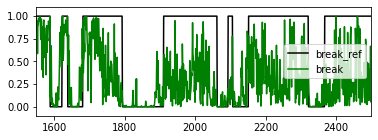

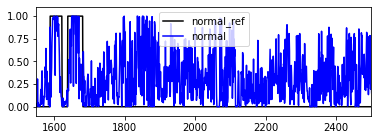

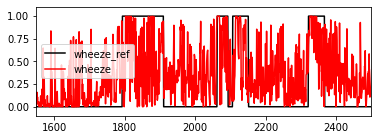

In [35]:
y_pred = model.predict(t2_x)

###################################### graph visuallization
y_pred_0 = y_pred[:,0]
y_pred_1 = y_pred[:,1]
y_pred_2 = y_pred[:,2]

y_test_0 = y_test[:,0]
y_test_1 = y_test[:,1]
y_test_2 = y_test[:,2]

view_start = 1550
view_end = 2500

# x = np.arange(len(y_test_0))

plt.figure(figsize=(6,2))
plt.plot(y_test_0, label='break_ref', color='black')
plt.plot(y_pred_0, label='break', color='g')
plt.ylim(-0.1,1.1)
plt.xlim(view_start,view_end)
plt.legend()
plt.savefig('svg_images/figure S6a_break.svg')

plt.figure(figsize=(6,2))
plt.plot(y_test_1, label='normal_ref', color='black')
plt.plot(y_pred_1, label='normal', color='b')
plt.ylim(-0.1,1.1)
plt.xlim(view_start,view_end)
plt.legend()
plt.savefig('svg_images/figure S6a_normal.svg')

plt.figure(figsize=(6,2))
plt.plot(y_test_2, label='wheeze_ref', color='black')
plt.plot(y_pred_2, label='wheeze', color='r')
plt.ylim(-0.1,1.1)
plt.xlim(view_start,view_end)
plt.legend()
plt.savefig('svg_images/figure S6a_wheeze.svg')

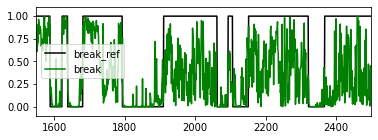

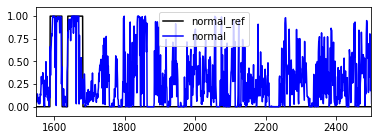

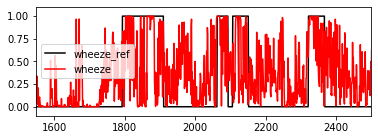

In [36]:
y_pred = model.predict(t2_x_nr)

###################################### graph visuallization
y_pred_0 = y_pred[:,0]
y_pred_1 = y_pred[:,1]
y_pred_2 = y_pred[:,2]

y_test_0 = y_test[:,0]
y_test_1 = y_test[:,1]
y_test_2 = y_test[:,2]

view_start = 1550
view_end = 2500

# x = np.arange(len(y_test_0))

plt.figure(figsize=(6,2))
plt.plot(y_test_0, label='break_ref', color='black')
plt.plot(y_pred_0, label='break', color='g')
plt.ylim(-0.1,1.1)
plt.xlim(view_start,view_end)
plt.legend()
plt.savefig('svg_images/figure S6b_break.svg')

plt.figure(figsize=(6,2))
plt.plot(y_test_1, label='normal_ref', color='black')
plt.plot(y_pred_1, label='normal', color='b')
plt.ylim(-0.1,1.1)
plt.xlim(view_start,view_end)
plt.legend()
plt.savefig('svg_images/figure S6b_normal.svg')

plt.figure(figsize=(6,2))
plt.plot(y_test_2, label='wheeze_ref', color='black')
plt.plot(y_pred_2, label='wheeze', color='r')
plt.ylim(-0.1,1.1)
plt.xlim(view_start,view_end)
plt.legend()
plt.savefig('svg_images/figure S6b_wheeze.svg')

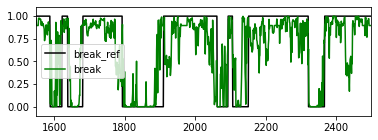

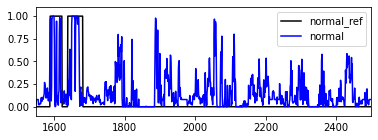

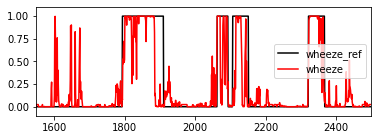

In [37]:
y_pred = model.predict(t2_x_nr2)

###################################### graph visuallization
y_pred_0 = y_pred[:,0]
y_pred_1 = y_pred[:,1]
y_pred_2 = y_pred[:,2]

y_test_0 = y_test[:,0]
y_test_1 = y_test[:,1]
y_test_2 = y_test[:,2]

view_start = 1550
view_end = 2500

# x = np.arange(len(y_test_0))

plt.figure(figsize=(6,2))
plt.plot(y_test_0, label='break_ref', color='black')
plt.plot(y_pred_0, label='break', color='g')
plt.ylim(-0.1,1.1)
plt.xlim(view_start,view_end)
plt.legend()
plt.savefig('svg_images/figure S6c_break.svg')

plt.figure(figsize=(6,2))
plt.plot(y_test_1, label='normal_ref', color='black')
plt.plot(y_pred_1, label='normal', color='b')
plt.ylim(-0.1,1.1)
plt.xlim(view_start,view_end)
plt.legend()
plt.savefig('svg_images/figure S6c_normal.svg')

plt.figure(figsize=(6,2))
plt.plot(y_test_2, label='wheeze_ref', color='black')
plt.plot(y_pred_2, label='wheeze', color='r')
plt.ylim(-0.1,1.1)
plt.xlim(view_start,view_end)
plt.legend()
plt.savefig('svg_images/figure S6c_wheeze.svg')

## Test for wheeze counter 

In [80]:
n_mels = 128
frame_sec = 0.025
step_sec = 0.01
label_ratio = 1

In [81]:
test_file_path= 'data/test'
test_file_list = os.listdir(test_file_path)
ordered_test_file_list = natsort.natsorted(test_file_list)
ordered_test_file_list

['1_clinical(s1_1)_JJY_extrcted.txt',
 '1_clinical(s1_1)_JJY_extrcted.wav',
 '1_clinical(s1_1)_JJY_extrcted_ISH.txt',
 '1_clinical(s1_1)_JJY_extrcted_ISH.wav',
 '1_clinical(s1_1)_JJY_extrcted_ISH_noisty.txt',
 '1_clinical(s1_1)_JJY_extrcted_ISH_noisy.wav',
 '1_clinical(s1_1)_JJY_extrcted_ISH_volume_up.txt',
 '1_clinical(s1_1)_JJY_extrcted_ISH_volume_up.wav',
 '2_clinical(202109301404_1_f)JJY final_extracted.txt',
 '2_clinical(202109301404_1_f)JJY final_extracted.wav',
 '2_clinical(202109301404_1_f)JJY final_extracted_2.txt',
 '2_clinical(202109301404_1_f)JJY final_extracted_2.wav',
 'extracted_clinical.txt',
 'extracted_clinical.wav',
 'infant_wheeze_test3-4.txt',
 'infant_wheeze_test3-4.wav']

In [82]:
index = 1
sample_rate = librosa.get_samplerate(test_file_path + '/' + ordered_test_file_list[index])
t1, t1_sr = librosa.load(test_file_path + '/' + ordered_test_file_list[index], sr = sample_rate)
t1_nr = nr.reduce_noise(t1, sr = sample_rate, n_std_thresh_stationary=0.1, stationary=True)
# t1_nr = nr.reduce_noise(t1, sr = sample_rate)
t1_label = pd.read_csv(test_file_path + '/' + ordered_test_file_list[index-1], sep='\t', header=None)

index = 3
sample_rate = librosa.get_samplerate(test_file_path + '/' + ordered_test_file_list[index])
t2, t2_sr = librosa.load(test_file_path + '/' + ordered_test_file_list[index], sr = sample_rate)
# t2_nr = nr.reduce_noise(t2, sr = sample_rate, n_std_thresh_stationary=0.1, stationary=True)
t2_nr = nr.reduce_noise(t2, sr = sample_rate)
t2_label = pd.read_csv(test_file_path + '/' + ordered_test_file_list[index-1], sep='\t', header=None)

index = 5
sample_rate = librosa.get_samplerate(test_file_path + '/' + ordered_test_file_list[index])
t3, t3_sr = librosa.load(test_file_path + '/' + ordered_test_file_list[index], sr = sample_rate)
# t3_nr = nr.reduce_noise(t3, sr = sample_rate, n_std_thresh_stationary=0.1, stationary=True)
t3_nr = nr.reduce_noise(t3, sr = sample_rate)
t3_label = pd.read_csv(test_file_path + '/' + ordered_test_file_list[index-1], sep='\t', header=None)

index = 7
sample_rate = librosa.get_samplerate(test_file_path + '/' + ordered_test_file_list[index])
t4, t4_sr = librosa.load(test_file_path + '/' + ordered_test_file_list[index], sr = sample_rate)
t4_nr = nr.reduce_noise(t4, sr = sample_rate, n_std_thresh_stationary=0.1, stationary=True)
# t4_nr = nr.reduce_noise(t4, sr = sample_rate)
t4_label = pd.read_csv(test_file_path + '/' + ordered_test_file_list[index-1], sep='\t', header=None)

index = 9
sample_rate = librosa.get_samplerate(test_file_path + '/' + ordered_test_file_list[index])
t5, t5_sr = librosa.load(test_file_path + '/' + ordered_test_file_list[index], sr = sample_rate)
# t5_nr = nr.reduce_noise(t5, sr = sample_rate, n_std_thresh_stationary=0.1, stationary=True)
t5_nr = nr.reduce_noise(t5, sr = sample_rate)
t5_label = pd.read_csv(test_file_path + '/' + ordered_test_file_list[index-1], sep='\t', header=None)

index = 11
sample_rate = librosa.get_samplerate(test_file_path + '/' + ordered_test_file_list[index])
t6, t6_sr = librosa.load(test_file_path + '/' + ordered_test_file_list[index], sr = sample_rate)
t6_nr = nr.reduce_noise(t6, sr = sample_rate)
t6_label = pd.read_csv(test_file_path + '/' + ordered_test_file_list[index-1], sep='\t', header=None)

index = 13
sample_rate = librosa.get_samplerate(test_file_path + '/' + ordered_test_file_list[index])
t7, t7_sr = librosa.load(test_file_path + '/' + ordered_test_file_list[index], sr = sample_rate)
t7_nr = nr.reduce_noise(t7, sr = sample_rate)
t7_label = pd.read_csv(test_file_path + '/' + ordered_test_file_list[index-1], sep='\t', header=None)

index = 15
sample_rate = librosa.get_samplerate(test_file_path + '/' + ordered_test_file_list[index])
t8, t8_sr = librosa.load(test_file_path + '/' + ordered_test_file_list[index], sr = sample_rate)
t8_nr = nr.reduce_noise(t7, sr = sample_rate)
t8_label = pd.read_csv(test_file_path + '/' + ordered_test_file_list[index-1], sep='\t', header=None)

In [83]:
## laebl 범위로 지정: realtime, label event 지정: realtime_2
t1_x, t1_y = make_test_dataset_keras_realtime_2(t1, t1_label, n_mels, frame_sec, step_sec, sample_rate)
t2_x, t2_y = make_test_dataset_keras_realtime(t2, t2_label, n_mels, frame_sec, step_sec, sample_rate)
t3_x, t3_y = make_test_dataset_keras_realtime(t3, t3_label, n_mels, frame_sec, step_sec, sample_rate)
t4_x, t4_y = make_test_dataset_keras_realtime(t4, t4_label, n_mels, frame_sec, step_sec, sample_rate)
t5_x, t5_y = make_test_dataset_keras_realtime_2(t5, t5_label, n_mels, frame_sec, step_sec, sample_rate)
# t6_x, t6_y = make_test_dataset_keras_realtime_2(t6[:60*16000], t6_label, n_mels, frame_sec, step_sec, sample_rate)
t7_x, t7_y = make_test_dataset_keras_realtime_2(t7, t7_label, n_mels, frame_sec, step_sec, sample_rate)
t8_x, t8_y = make_test_dataset_keras_realtime_2(t8, t8_label, n_mels, frame_sec, step_sec, sample_rate)

t1_x_nr, t1_y = make_test_dataset_keras_realtime_2(t1_nr, t1_label, n_mels, frame_sec, step_sec, sample_rate)
t2_x_nr, t2_y = make_test_dataset_keras_realtime(t2_nr, t2_label, n_mels, frame_sec, step_sec, sample_rate)
t3_x_nr, t3_y = make_test_dataset_keras_realtime(t3_nr, t3_label, n_mels, frame_sec, step_sec, sample_rate)
t4_x_nr, t4_y = make_test_dataset_keras_realtime(t4_nr, t4_label, n_mels, frame_sec, step_sec, sample_rate)
t5_x_nr, t5_y = make_test_dataset_keras_realtime_2(t5_nr, t5_label, n_mels, frame_sec, step_sec, sample_rate)
# t6_x_nr, t6_y = make_test_dataset_keras_realtime_2(t6_nr[:60*16000], t6_label, n_mels, frame_sec, step_sec, sample_rate)
t7_x_nr, t7_y = make_test_dataset_keras_realtime_2(t7_nr, t7_label, n_mels, frame_sec, step_sec, sample_rate)
t8_x_nr, t8_y = make_test_dataset_keras_realtime_2(t8_nr, t8_label, n_mels, frame_sec, step_sec, sample_rate)

In [84]:
# 1dCNN bLSTM
model = load_model('saved_model/230730_1dCNN_bLSTM_larger_dataset_with_ICBHI_ref_npmax_k_fold_10_train_with_9_best_acc_fix_sample_rate_error')
# model = load_model('saved_model/230730_1dCNN_bLSTM_larger_dataset_with_ICBHI_ref_npmax_k_fold_10_train_with_9_best_acc')
# model = load_model('saved_model/230730_1dCNN_bLSTM_larger_dataset_with_ICBHI_ref_npmax')

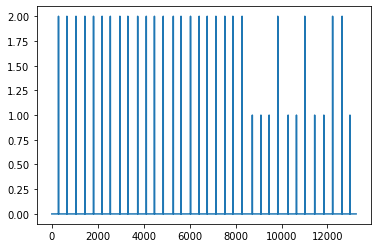

In [85]:
t1_y.shape
plt.plot(t1_y)

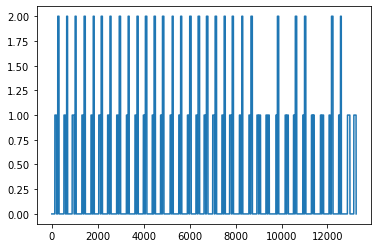

In [86]:
t2_y.shape
plt.plot(t2_y)

acc: 0.7552637536789676
f1: 0.8584853916556675
roc_auc: 0.5771509789991245
[[10000  2655   562]
 [    5     3     0]
 [   16     5     5]]


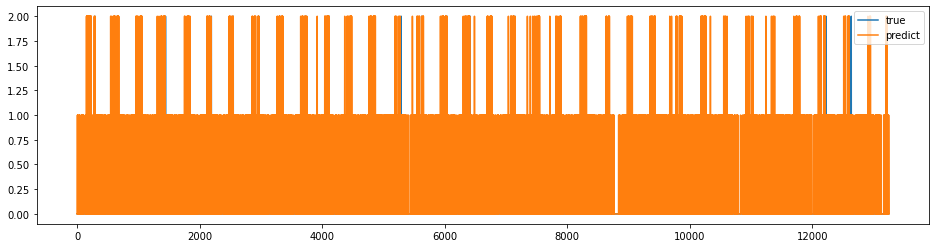

In [87]:
y_pred = model.predict(t1_x)

predict=[]
for i in  y_pred:
    predict.append(np.argmax(i))

predict = np.array(predict)

acc = accuracy_score(t1_y, predict)
f1 = f1_score(t1_y, predict, average='weighted')
roc_auc = roc_auc_score(utils.to_categorical(t1_y), utils.to_categorical(predict), multi_class='ovr')
cm = confusion_matrix(t1_y, predict)

print('acc:', acc)
print('f1:', f1)
print('roc_auc:', roc_auc)
print(cm)

plt.figure(figsize=(16,4))
plt.plot(t1_y, label = 'true')
plt.plot(predict, label = 'predict')

plt.legend()

acc: 0.8655195834276659
f1: 0.9256018512224008
roc_auc: 0.5334466727622688
[[11463  1004   750]
 [    8     0     0]
 [   18     2     6]]


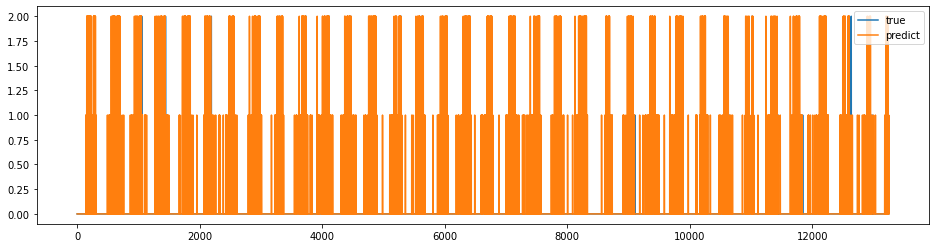

In [88]:
y_pred = model.predict(t1_x_nr)

predict=[]
for i in  y_pred:
    predict.append(np.argmax(i))

predict = np.array(predict)

acc = accuracy_score(t1_y, predict)
f1 = f1_score(t1_y, predict, average='weighted')
roc_auc = roc_auc_score(utils.to_categorical(t1_y), utils.to_categorical(predict), multi_class='ovr')
cm = confusion_matrix(t1_y, predict)

print('acc:', acc)
print('f1:', f1)
print('roc_auc:', roc_auc)
print(cm)

plt.figure(figsize=(16,4))
plt.plot(t1_y, label = 'true')
plt.plot(predict, label = 'predict')

plt.legend()

acc: 0.6071239906422157
f1: 0.6056647087556393
roc_auc: 0.5675461432510832
[[6971 2165  161]
 [1467  817   82]
 [ 861  470  257]]


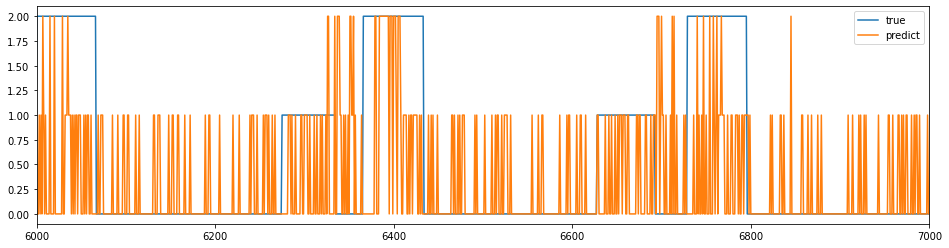

In [89]:
y_pred = model.predict(t2_x)

predict=[]
for i in  y_pred:
    predict.append(np.argmax(i))

predict = np.array(predict)

acc = accuracy_score(t2_y, predict)
f1 = f1_score(t2_y, predict, average='weighted')
roc_auc = roc_auc_score(utils.to_categorical(t2_y), utils.to_categorical(predict), multi_class='ovr')
cm = confusion_matrix(t2_y, predict)

print('acc:', acc)
print('f1:', f1)
print('roc_auc:', roc_auc)
print(cm)

plt.figure(figsize=(16,4))
plt.plot(t2_y, label = 'true')
plt.plot(predict, label = 'predict')
plt.xlim(6000, 7000)

plt.legend()

acc: 0.6590446004075164
f1: 0.6267315916944927
roc_auc: 0.5583533836131435
[[8184  462  651]
 [1863  378  125]
 [ 542  875  171]]


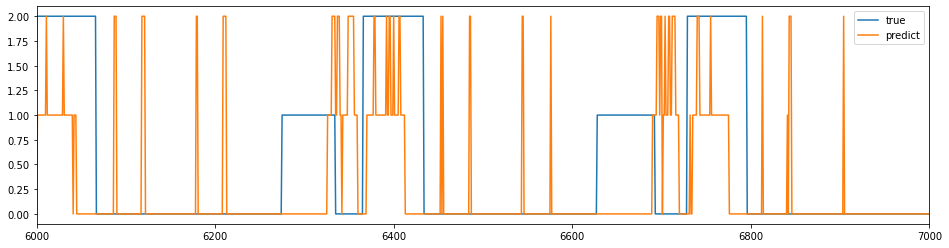

In [90]:
y_pred = model.predict(t2_x_nr)

predict=[]
for i in  y_pred:
    predict.append(np.argmax(i))

predict = np.array(predict)

acc = accuracy_score(t2_y, predict)
f1 = f1_score(t2_y, predict, average='weighted')
roc_auc = roc_auc_score(utils.to_categorical(t2_y), utils.to_categorical(predict), multi_class='ovr')
cm = confusion_matrix(t2_y, predict)

print('acc:', acc)
print('f1:', f1)
print('roc_auc:', roc_auc)
print(cm)

plt.figure(figsize=(16,4))
plt.plot(t2_y, label = 'true')
plt.plot(predict, label = 'predict')
plt.xlim(6000, 7000)

plt.legend()

acc: 0.6056901365934646
f1: 0.6040564596820391
roc_auc: 0.5638437149375146
[[7010 2027  260]
 [1534  686  146]
 [ 895  363  330]]


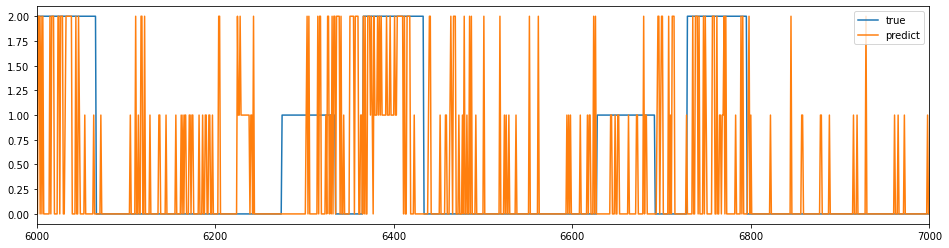

In [91]:
y_pred = model.predict(t3_x)

predict=[]
for i in  y_pred:
    predict.append(np.argmax(i))

predict = np.array(predict)

acc = accuracy_score(t3_y, predict)
f1 = f1_score(t3_y, predict, average='weighted')
roc_auc = roc_auc_score(utils.to_categorical(t3_y), utils.to_categorical(predict), multi_class='ovr')
cm = confusion_matrix(t3_y, predict)

print('acc:', acc)
print('f1:', f1)
print('roc_auc:', roc_auc)
print(cm)

plt.figure(figsize=(16,4))
plt.plot(t3_y, label = 'true')
plt.plot(predict, label = 'predict')
plt.xlim(6000, 7000)

plt.legend()

acc: 0.6536110482227756
f1: 0.6205633682191662
roc_auc: 0.5531218784815484
[[8120  638  539]
 [1887  346  133]
 [ 635  758  195]]


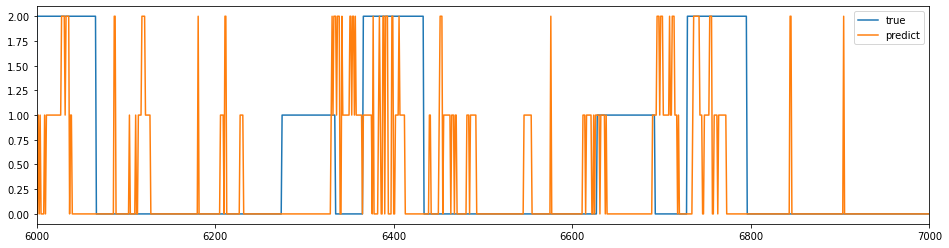

In [92]:
y_pred = model.predict(t3_x_nr)

predict=[]
for i in  y_pred:
    predict.append(np.argmax(i))

predict = np.array(predict)

acc = accuracy_score(t3_y, predict)
f1 = f1_score(t3_y, predict, average='weighted')
roc_auc = roc_auc_score(utils.to_categorical(t3_y), utils.to_categorical(predict), multi_class='ovr')
cm = confusion_matrix(t3_y, predict)

print('acc:', acc)
print('f1:', f1)
print('roc_auc:', roc_auc)
print(cm)

plt.figure(figsize=(16,4))
plt.plot(t3_y, label = 'true')
plt.plot(predict, label = 'predict')
plt.xlim(6000, 7000)

plt.legend()

acc: 0.6394927536231884
f1: 0.6260192194227832
roc_auc: 0.5729740129010156
[[7504 1632  158]
 [1574  677  115]
 [ 921  376  291]]


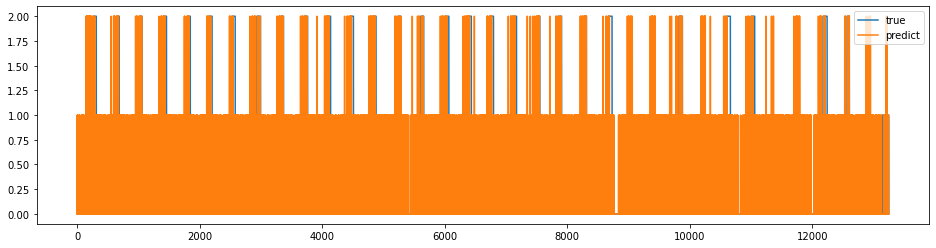

In [74]:
y_pred = model.predict(t4_x)

predict=[]
for i in  y_pred:
    predict.append(np.argmax(i))

predict = np.array(predict)

acc = accuracy_score(t4_y, predict)
f1 = f1_score(t4_y, predict, average='weighted')
roc_auc = roc_auc_score(utils.to_categorical(t4_y), utils.to_categorical(predict), multi_class='ovr')
cm = confusion_matrix(t4_y, predict)

print('acc:', acc)
print('f1:', f1)
print('roc_auc:', roc_auc)
print(cm)

plt.figure(figsize=(16,4))
plt.plot(t4_y, label = 'true')
plt.plot(predict, label = 'predict')

plt.legend()

acc: 0.7070501207729468
f1: 0.6570047311515431
roc_auc: 0.5802722629149847
[[8675  402  217]
 [1798  355  213]
 [1059  192  337]]


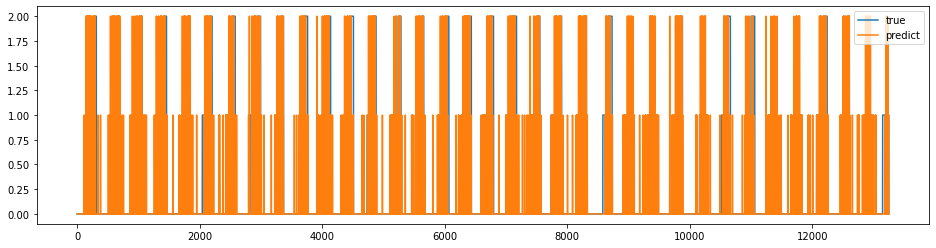

In [72]:
y_pred = model.predict(t4_x_nr)

predict=[]
for i in  y_pred:
    predict.append(np.argmax(i))

predict = np.array(predict)

acc = accuracy_score(t4_y, predict)
f1 = f1_score(t4_y, predict, average='weighted')
roc_auc = roc_auc_score(utils.to_categorical(t4_y), utils.to_categorical(predict), multi_class='ovr')
cm = confusion_matrix(t4_y, predict)

print('acc:', acc)
print('f1:', f1)
print('roc_auc:', roc_auc)
print(cm)

plt.figure(figsize=(16,4))
plt.plot(t4_y, label = 'true')
plt.plot(predict, label = 'predict')

plt.legend()

acc: 0.8407985666751984
f1: 0.9108912450255869
roc_auc: 0.5370373214158791
[[9852 1245  584]
 [  13    2    2]
 [  12   10    1]]


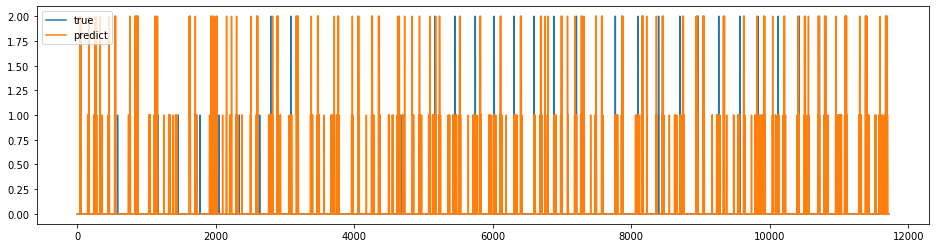

In [73]:
y_pred = model.predict(t5_x_nr)

predict=[]
for i in  y_pred:
    predict.append(np.argmax(i))

predict = np.array(predict)

acc = accuracy_score(t5_y, predict)
f1 = f1_score(t5_y, predict, average='weighted')
roc_auc = roc_auc_score(utils.to_categorical(t5_y), utils.to_categorical(predict), multi_class='ovr')
cm = confusion_matrix(t5_y, predict)

print('acc:', acc)
print('f1:', f1)
print('roc_auc:', roc_auc)
print(cm)

plt.figure(figsize=(16,4))
plt.plot(t5_y, label = 'true')
plt.plot(predict, label = 'predict')

plt.legend()

acc: 0.7367105482419597
f1: 0.8384709459542908
roc_auc: 0.4731579226886991
[[4417  797  708]
 [  44    3    0]
 [  15   16    1]]


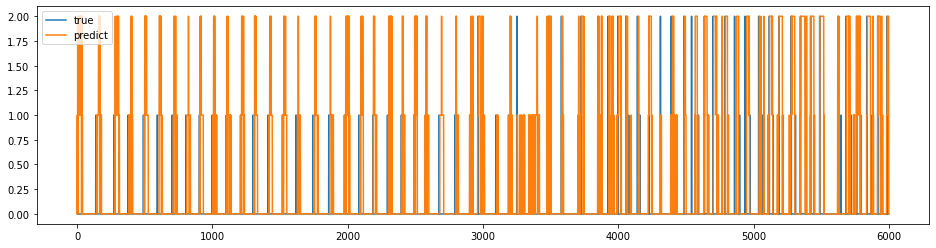

In [55]:
y_pred = model.predict(t7_x_nr)

predict=[]
for i in  y_pred:
    predict.append(np.argmax(i))

predict = np.array(predict)

acc = accuracy_score(t7_y, predict)
f1 = f1_score(t7_y, predict, average='weighted')
roc_auc = roc_auc_score(utils.to_categorical(t7_y), utils.to_categorical(predict), multi_class='ovr')
cm = confusion_matrix(t7_y, predict)

print('acc:', acc)
print('f1:', f1)
print('roc_auc:', roc_auc)
print(cm)

plt.figure(figsize=(16,4))
plt.plot(t7_y, label = 'true')
plt.plot(predict, label = 'predict')

plt.legend()